In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as const
from scipy.integrate import solve_ivp
import pandas as pd
from tabulate import tabulate
from ipywidgets import interactive, FloatLogSlider
import ipywidgets as wd
from IPython.display import display

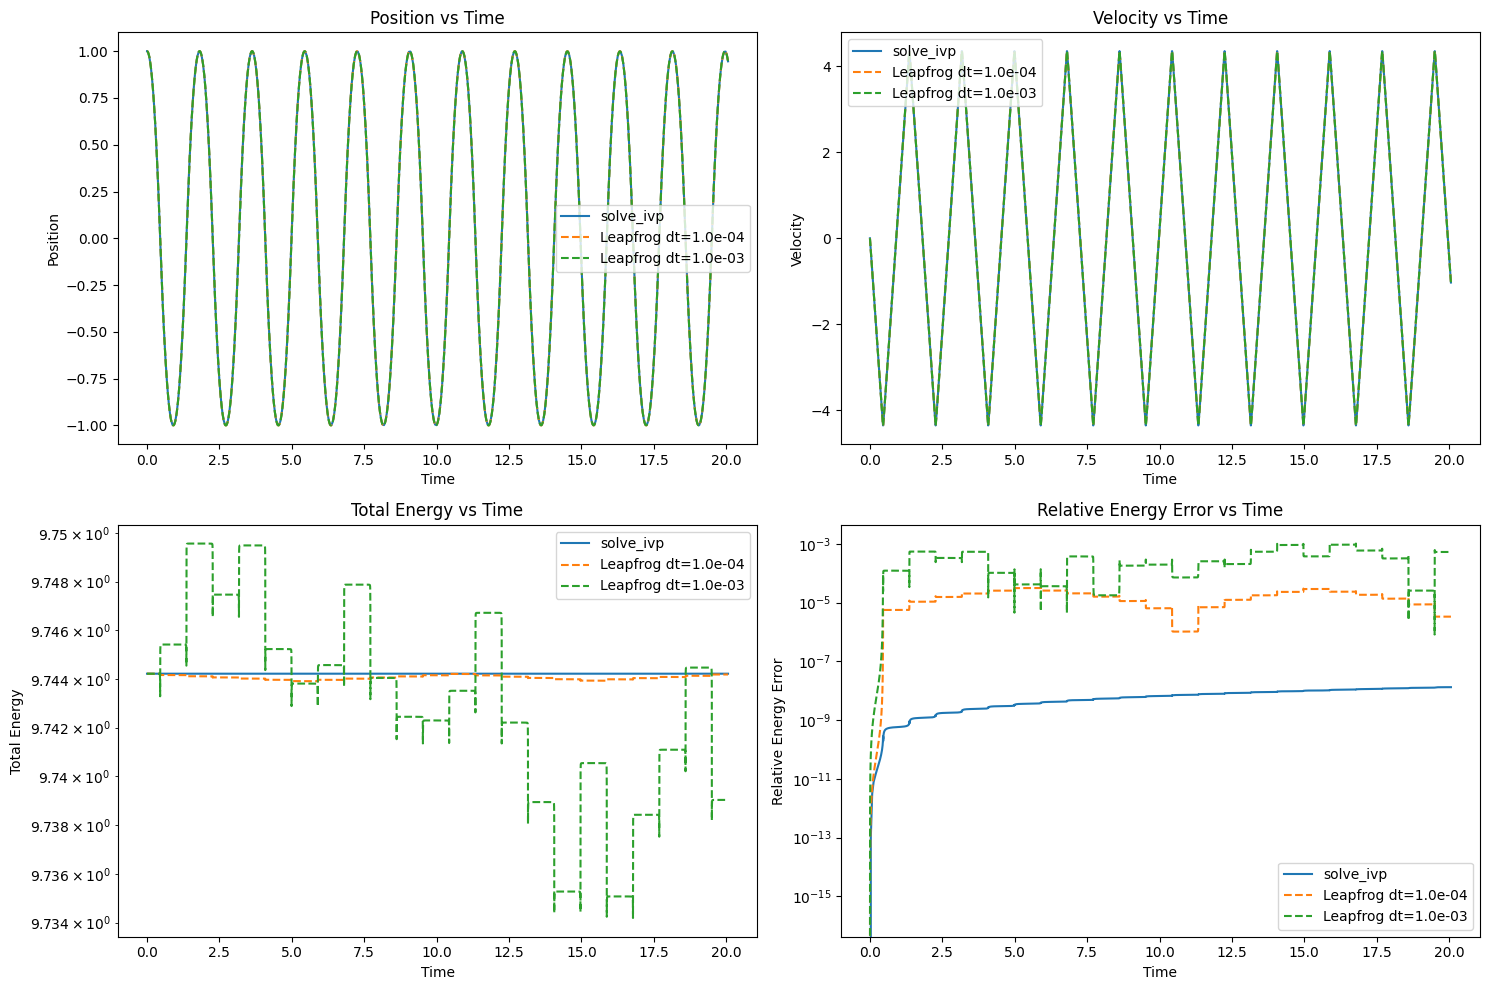

In [4]:
#Comparing 

# Parameters
orbits = 10
x0 = 1
v0 = 0
x_s = 0.01
T = 2 * np.pi * np.sqrt(x0/const.g)  # Time Orbit

def force(x, x_s):
    return -const.g * 2 / np.pi * np.arctan(x / x_s)

def total_energy(x, v, x_s):
    potential = -const.g / np.pi * (np.log(x**2 + x_s**2) * x_s - 2 * x * np.arctan(x/x_s))
    kinetic = 0.5 * v**2
    energy = kinetic + potential
    return energy

def system(t, y, x_s):
    x, v = y
    return [v, force(x, x_s)]

def numerical_solution(x0, v0, x_s, dt, T, orbits):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    
    x = np.zeros(h)
    v = np.zeros(h)
    energy = np.zeros(h)
    x[0] = x0
    v[0] = v0
    energy[0] = total_energy(x[0], v[0], x_s)
    
    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force(x[i],x_s)
        x[i+1] = x[i] + dt * v[i+1]
        if x[i] * x[i+1] < 0:
            v_half = v[i] + dt * 0.5 * force(x[i],x_s)
            v_b = v[i] + (-x[i]/v_half) * force(x[i],x_s)
            x[i+1] = x[i] + v_half * dt
            v[i+1] = v_b + ((x[i]/v_half) + dt) * force(x[i+1],x_s)
        else:
            v[i+1] = v[i+1] + 0.5 * dt * force(x[i+1],x_s)
        energy[i+1] = total_energy(x[i+1], v[i+1],x_s)
    
    return t, x, v, energy

def ivp_solution(x0, v0, x_s, T, orbits):
    t_span = (0, orbits * T)
    y0 = [x0, v0]
    sol = solve_ivp(system, t_span, y0, args=(x_s,), method='RK45', rtol=1e-10, atol=1e-10)
    energy = total_energy(sol.y[0], sol.y[1], x_s)
    return sol.t, sol.y[0], sol.y[1], energy

t_ivp, x_ivp, v_ivp, e_ivp = ivp_solution(x0, v0, x_s, T, orbits)

stepsizes = np.logspace(-4, -3, 2)
leapfrog_results = [numerical_solution(x0, v0, x_s, dt, T, orbits) for dt in stepsizes]

# Plotting
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(t_ivp, x_ivp, label='solve_ivp')
for i, (t, x, _, _) in enumerate(leapfrog_results):
    plt.plot(t, x, label=f'Leapfrog dt={stepsizes[i]:.1e}', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position vs Time')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(t_ivp, v_ivp, label='solve_ivp')
for i, (t, _, v, _) in enumerate(leapfrog_results):
    plt.plot(t, v, label=f'Leapfrog dt={stepsizes[i]:.1e}', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity vs Time')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(t_ivp, e_ivp, label='solve_ivp')
for i, (t, _, _, e) in enumerate(leapfrog_results):
       plt.plot(t, e, label=f'Leapfrog dt={stepsizes[i]:.1e}', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Total Energy')
plt.yscale("log")
plt.title('Total Energy vs Time')
plt.legend()

plt.subplot(2, 2, 4)
e_ivp_error = np.abs(e_ivp - e_ivp[0]) / e_ivp[0]
plt.semilogy(t_ivp, e_ivp_error, label='solve_ivp')
for i, (t, _, _, e) in enumerate(leapfrog_results):
    e_error = np.abs(e - e[0]) / e[0]
    plt.semilogy(t, e_error, label=f'Leapfrog dt={stepsizes[i]:.1e}', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Relative Energy Error')
plt.title('Relative Energy Error vs Time')
plt.legend()

plt.tight_layout()
plt.show()

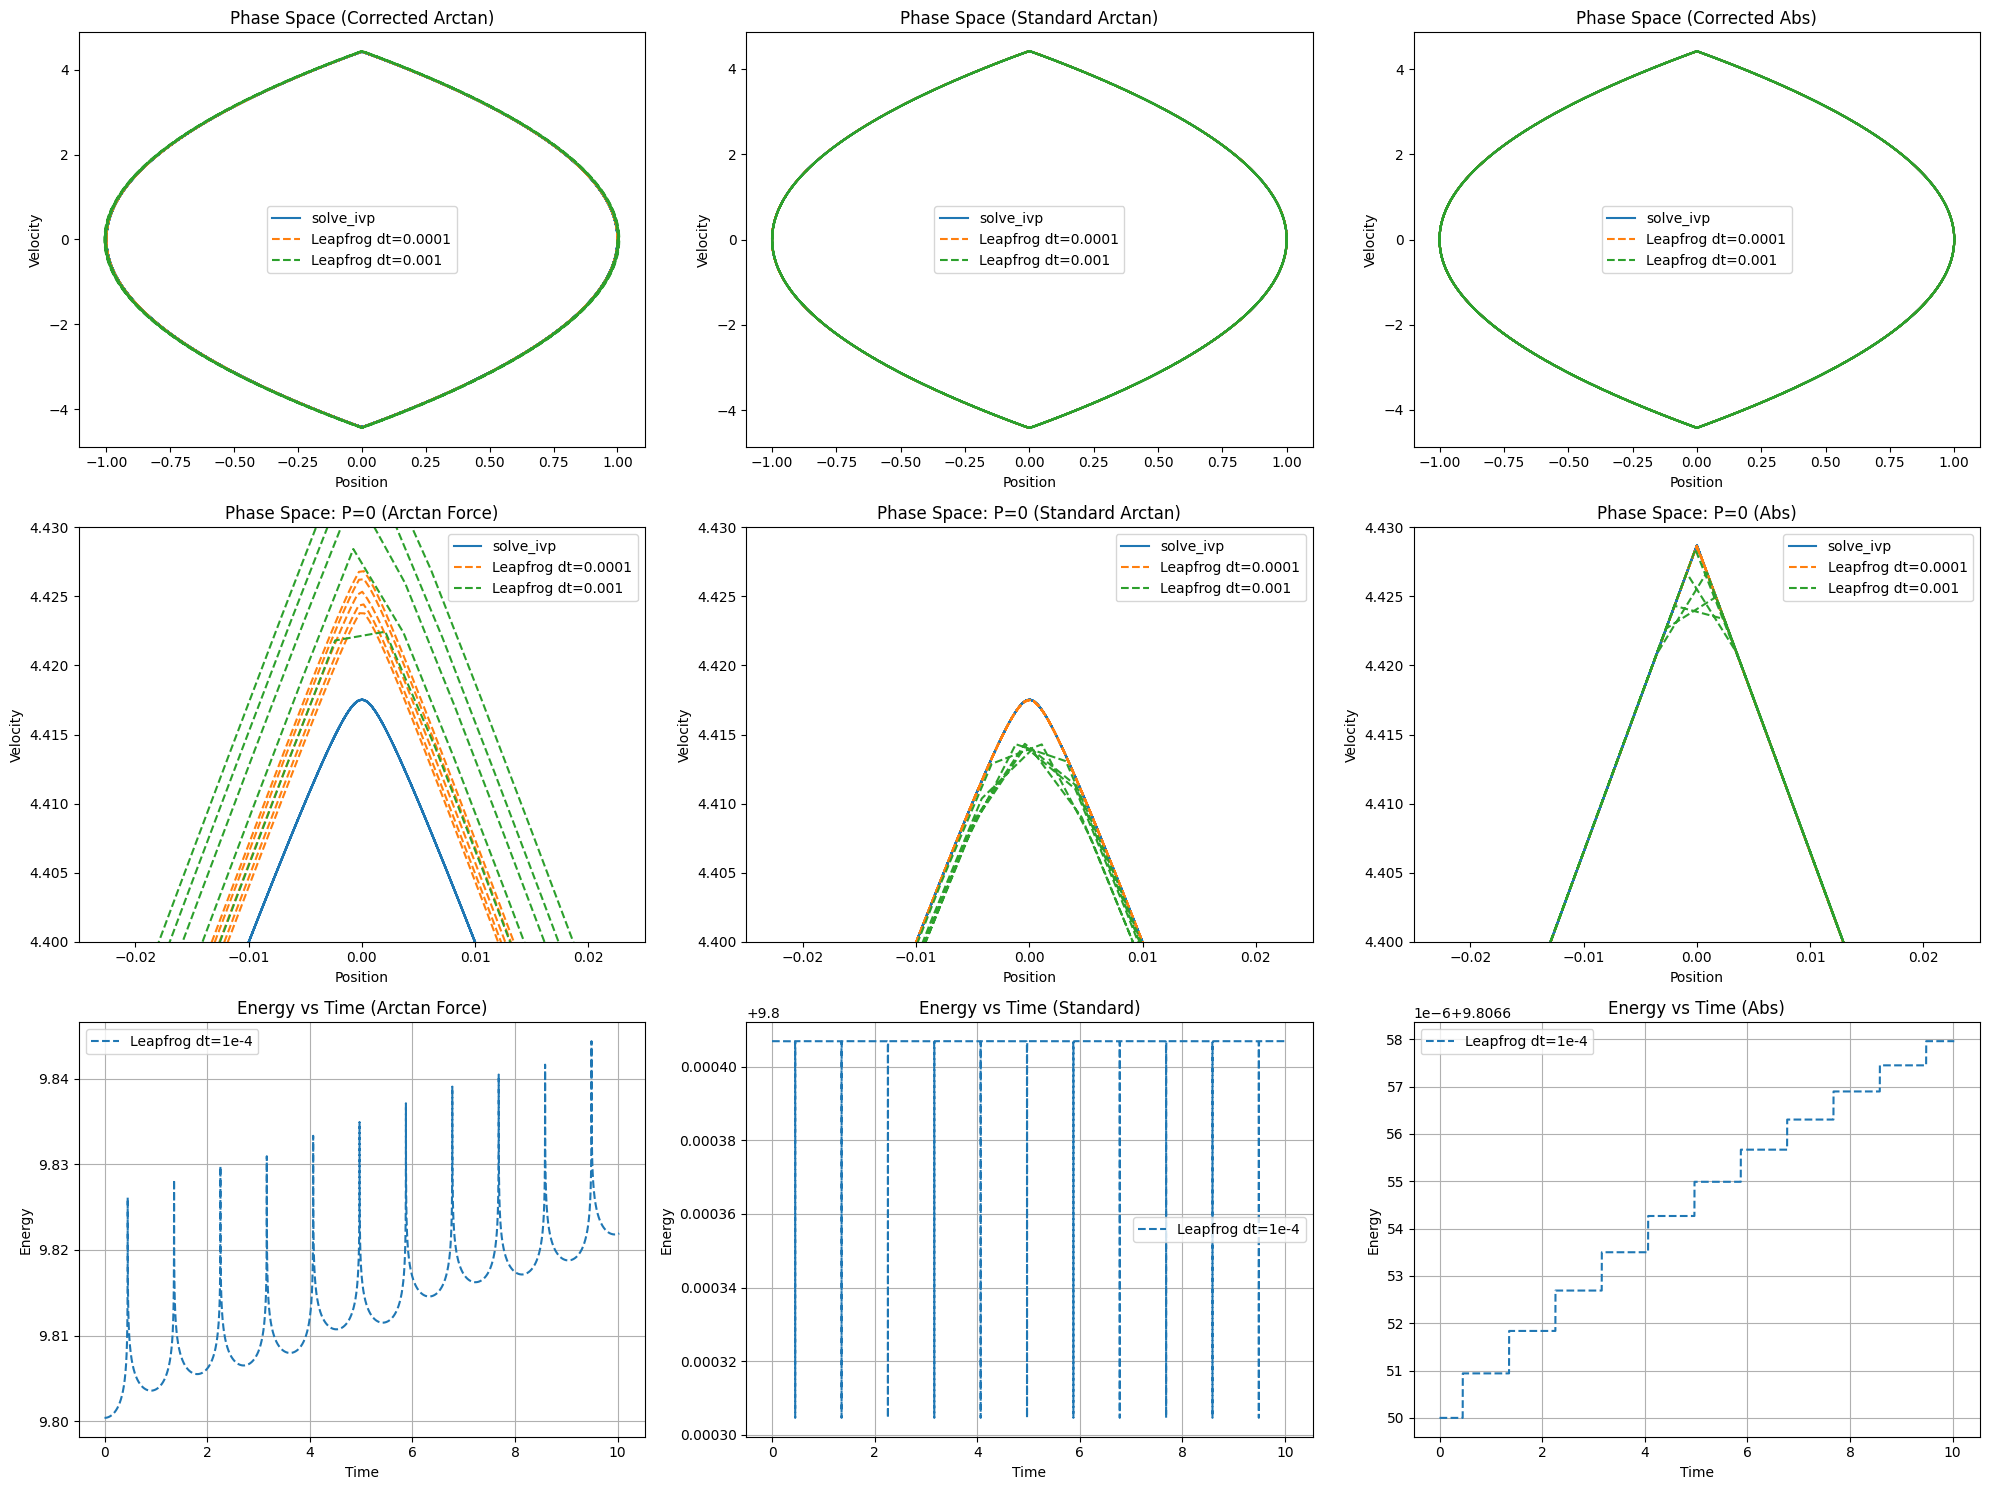

In [6]:
# Parameters
orbits = 5
x0 = 1
v0 = 0
T = 2 * np.pi * np.sqrt(x0/const.g) 
x_s = 0.001

# Force and energy functions
def create_force_arctan(x_s):
    return lambda x: -const.g * 2/np.pi * np.arctan(x/x_s)

def create_force_abs():
    return lambda x: -const.g * np.sign(x)

force_arctan = create_force_arctan(x_s)
force_abs = create_force_abs()

def total_energy_arctan(x, v, x_s):
    potential = -const.g / np.pi * (np.log(x**2 + x_s**2) * x_s - 2 * x * np.arctan(x/x_s))
    kinetic = 0.5 * v**2
    return kinetic + potential

def total_energy_abs(x, v):
    potential = const.g * np.abs(x)
    kinetic = 0.5 * v**2
    return kinetic + potential

# System functions for solve_ivp
def system_arctan(t, y):
    x, v = y
    return [v, force_arctan(x)]

def system_abs(t, y):
    x, v = y
    return [v, force_abs(x)]

# Numerical System Computing
def numerical_solution_arctan(x0, v0, x_s, force_arctan, dt, T, orbits):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)

    x = np.zeros(h)
    v = np.zeros(h)
    energy = np.zeros(h)

    x[0] = x0
    v[0] = v0
    energy[0] = total_energy_arctan(x[0], v[0], x_s)
    
    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_arctan(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        if x[i] * x[i+1] < 0:
            v_half = v[i] + dt * 0.5 * force_arctan(x[i])
            v_b = v[i] + (-x[i]/v_half) * force_arctan(x[i])
            x[i+1] = x[i] + v_half * dt
            v[i+1] = v_b + ((x[i]/v_half) + dt) * force_arctan(x[i+1])
        else:
            v[i+1] = v[i+1] + 0.5 * dt * force_abs(x[i+1])
        energy[i+1] = total_energy_arctan(x[i+1], v[i+1],x_s)
    return t, x, v, energy

def numerical_solution_abs(x0, v0, force_abs, dt, T, orbits):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)

    x = np.zeros(h)
    v = np.zeros(h)
    energy = np.zeros(h)

    x[0] = x0
    v[0] = v0
    energy[0] = total_energy_abs(x[0], v[0])
    
    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_abs(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        if x[i] * x[i+1] < 0:
            v_half = v[i] + dt * 0.5 * force_abs(x[i])
            v_b = v[i] + (-x[i]/v_half) * force_abs(x[i])
            x[i+1] = x[i] + v_half * dt
            v[i+1] = v_b + ((x[i]/v_half) + dt) * force_abs(x[i+1])
        else:
            v[i+1] = v[i+1] + 0.5 * dt * force_abs(x[i+1])
        energy[i+1] = total_energy_abs(x[i+1], v[i+1])
    return t, x, v, energy

def standard_leapfrog(x0, v0, force_arctan, dt, T, orbits):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    x = np.zeros(h)
    v = np.zeros(h)
    energy = np.zeros(h)
    x[0] = x0
    v[0] = v0
    energy[0] = total_energy_arctan(x[0], v[0], x_s)
    
    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_arctan(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        v[i+1] = v[i+1] + 0.5 * dt * force_arctan(x[i+1])
        energy[i+1] = total_energy_arctan(x[i+1], v[i+1], x_s)
    return t, x, v, energy

# Compute solutions
sol_arctan = solve_ivp(system_arctan, (0, orbits * T), [x0, v0], method='RK45', rtol=1e-10, atol=1e-10, max_step= dt)                      
t_ivp_arctan, x_ivp_arctan, v_ivp_arctan = sol_arctan.t, sol_arctan.y[0], sol_arctan.y[1]

sol_abs = solve_ivp(system_abs, (0, orbits * T), [x0, v0], method='RK45', rtol=1e-10, atol=1e-10, max_step = dt, )
t_ivp_abs, x_ivp_abs, v_ivp_abs = sol_abs.t, sol_abs.y[0], sol_abs.y[1]

stepsizes = [1e-4, 1e-3]
leapfrog_results_arctan = [numerical_solution_arctan(x0, v0, x_s, force_arctan, dt, T, orbits) for dt in stepsizes]
leapfrog_results_abs = [numerical_solution_abs(x0, v0, force_abs, dt, T, orbits) for dt in stepsizes]
leapfrog_standard = [standard_leapfrog(x0, v0, force_arctan, dt, T, orbits) for dt in stepsizes]

# Plotting
plt.figure(figsize=(20, 15))

#Arctan Plots
plt.subplot(3,3,1)
plt.plot(x_ivp_arctan, v_ivp_arctan, label='solve_ivp')
for i, (_, x, v, _) in enumerate(leapfrog_results_arctan):
    plt.plot(x, v, label=f'Leapfrog dt={stepsizes[i]}', linestyle='--')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Phase Space (Corrected Arctan)')
plt.legend()

plt.subplot(3,3,4)
plt.plot(x_ivp_arctan, v_ivp_arctan, label='solve_ivp')
for i, (_, x, v, _) in enumerate(leapfrog_results_arctan):
    plt.plot(x, v, label=f'Leapfrog dt={stepsizes[i]}', linestyle='--')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.xlim(-0.025,0.025)
plt.ylim(4.40,4.430)
plt.title('Phase Space: P=0 (Arctan Force)')
plt.legend()

plt.subplot(3,3,7)
t, _, _, energy = leapfrog_results_arctan[0]
plt.plot(t, energy, label='Leapfrog dt=1e-4', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy vs Time (Arctan Force)')
plt.grid()
plt.legend()

#Standard Plots
plt.subplot(3,3,2)
plt.plot(x_ivp_arctan, v_ivp_arctan, label='solve_ivp')
for i, (_, x, v, _) in enumerate(leapfrog_standard):
    plt.plot(x, v, label=f'Leapfrog dt={stepsizes[i]}', linestyle='--')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Phase Space (Standard Arctan)')
plt.legend()

plt.subplot(3,3,5)
plt.plot(x_ivp_arctan, v_ivp_arctan, label='solve_ivp')
for i, (_, x, v, _) in enumerate(leapfrog_standard):
    plt.plot(x, v, label=f'Leapfrog dt={stepsizes[i]}', linestyle='--')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.xlim(-0.025,0.025)
plt.ylim(4.40,4.430)
plt.title('Phase Space: P=0 (Standard Arctan)')
plt.legend()

plt.subplot(3,3,8)
t, _, _, energy = leapfrog_standard[0]
plt.plot(t, energy, label='Leapfrog dt=1e-4', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy vs Time (Standard)')
plt.grid()
plt.legend()

#Abs Plot
plt.subplot(3,3,3)
plt.plot(x_ivp_abs, v_ivp_abs, label='solve_ivp')
for i, (_, x, v, _) in enumerate(leapfrog_results_abs):
    plt.plot(x, v, label=f'Leapfrog dt={stepsizes[i]}', linestyle='--')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Phase Space (Corrected Abs)')
plt.legend()

plt.subplot(3,3,6)
plt.plot(x_ivp_abs, v_ivp_abs, label='solve_ivp')
for i, (_, x, v, _) in enumerate(leapfrog_results_abs):
    plt.plot(x, v, label=f'Leapfrog dt={stepsizes[i]}', linestyle='--')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.xlim(-0.025,0.025)
plt.ylim(4.40,4.430)
plt.title('Phase Space: P=0 (Abs)')
plt.legend()

plt.subplot(3,3,9)
t, _, _, energy = leapfrog_results_abs[0]
plt.plot(t, energy, label='Leapfrog dt=1e-4', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy vs Time (Abs)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

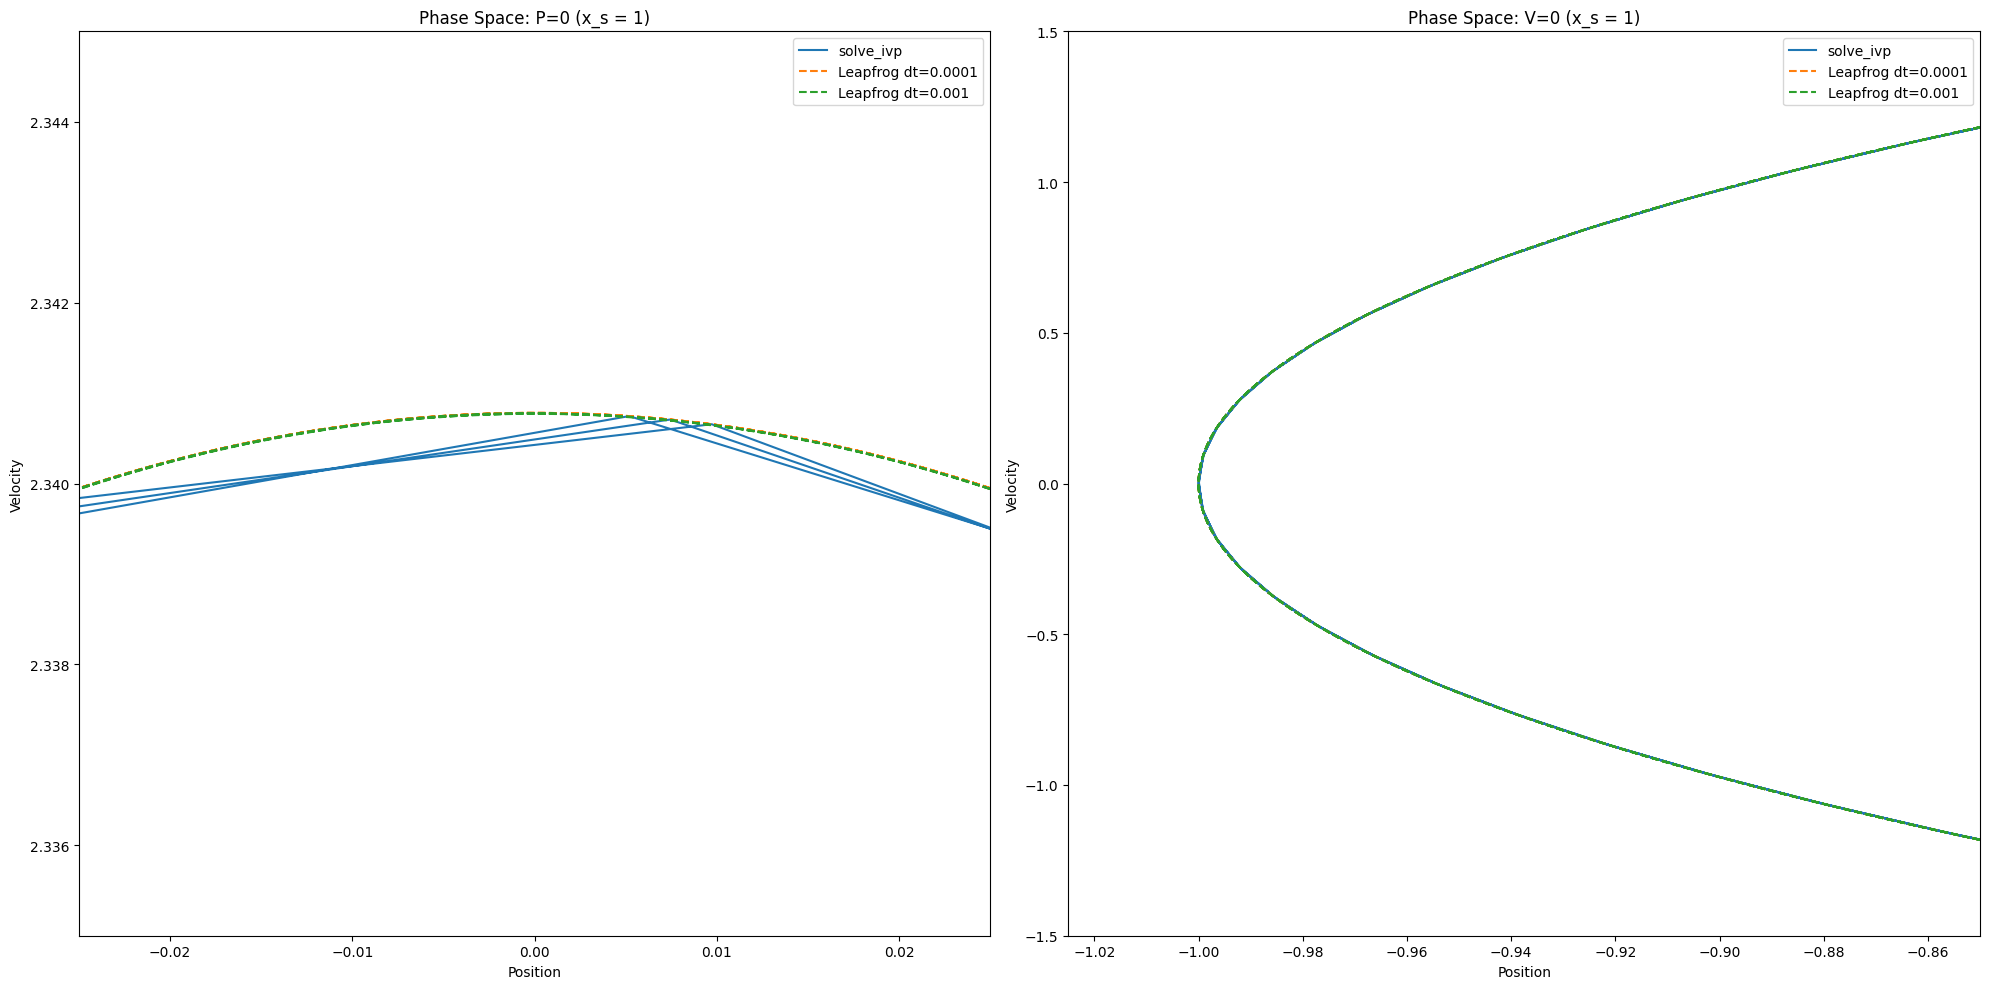

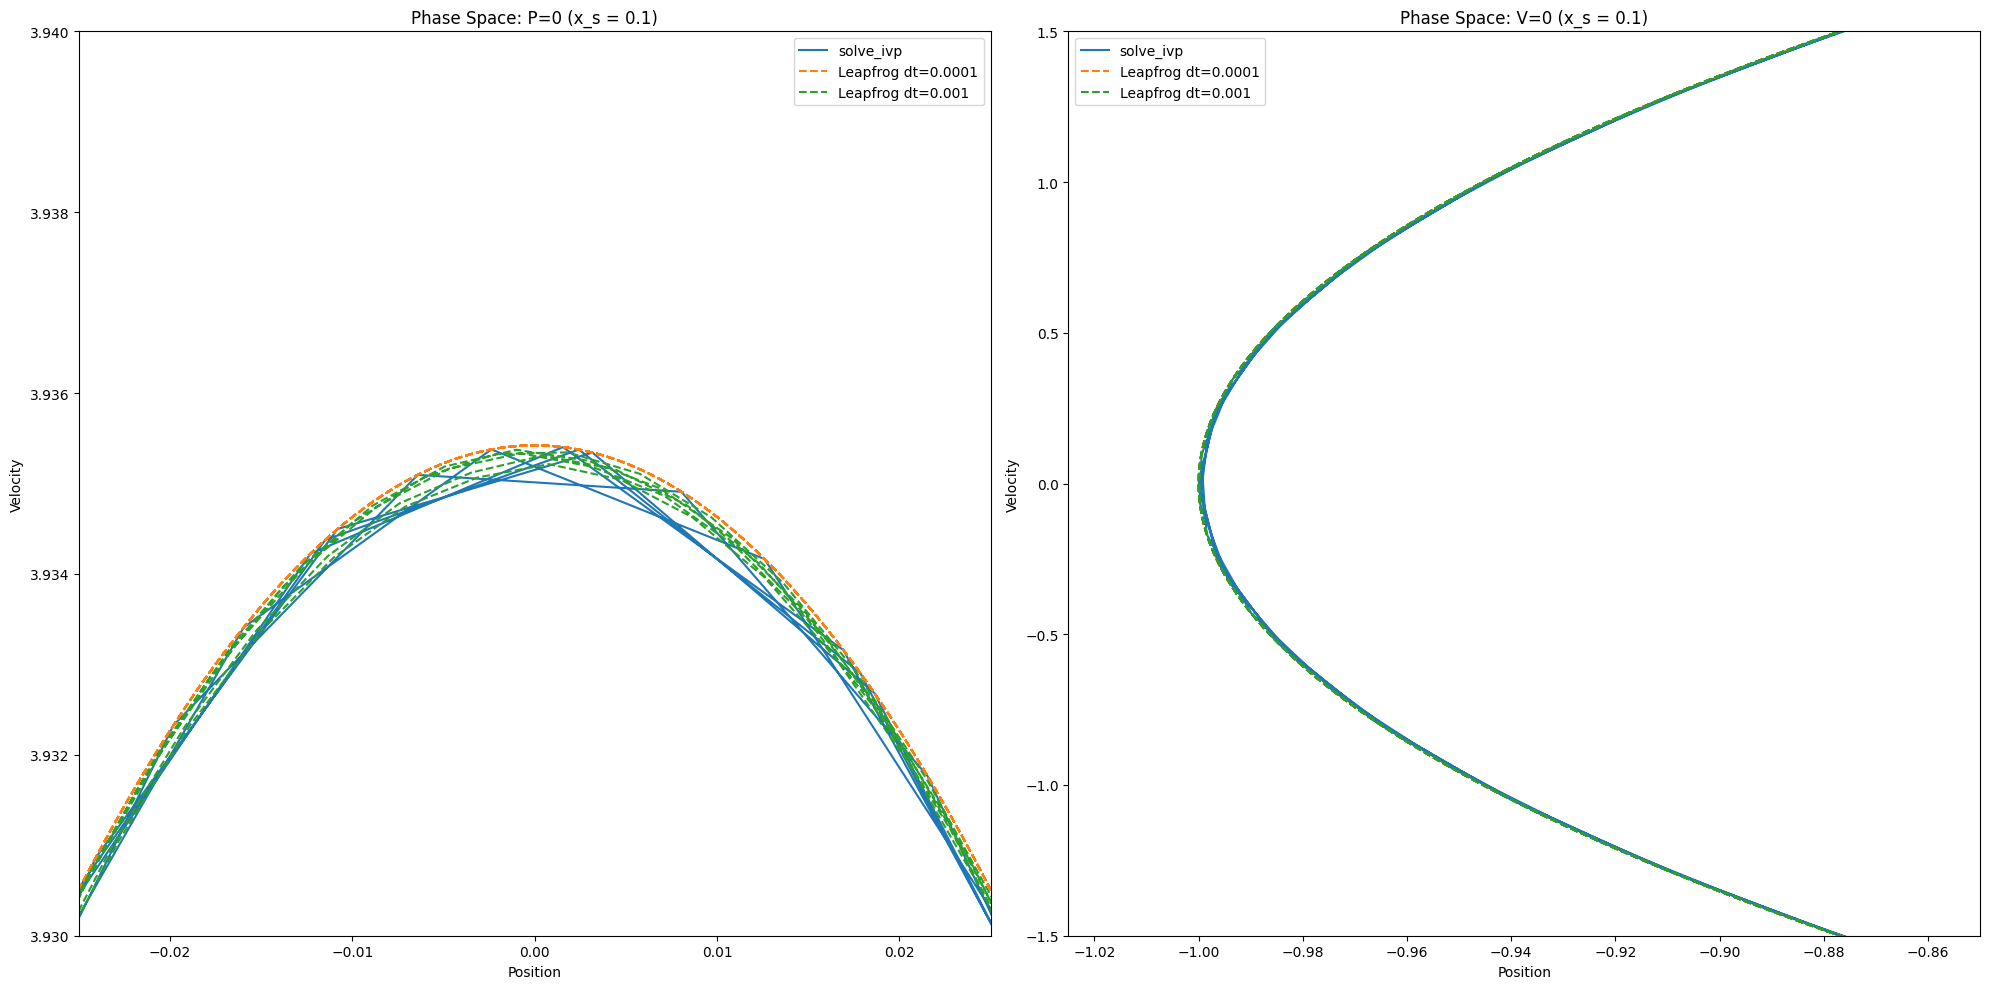

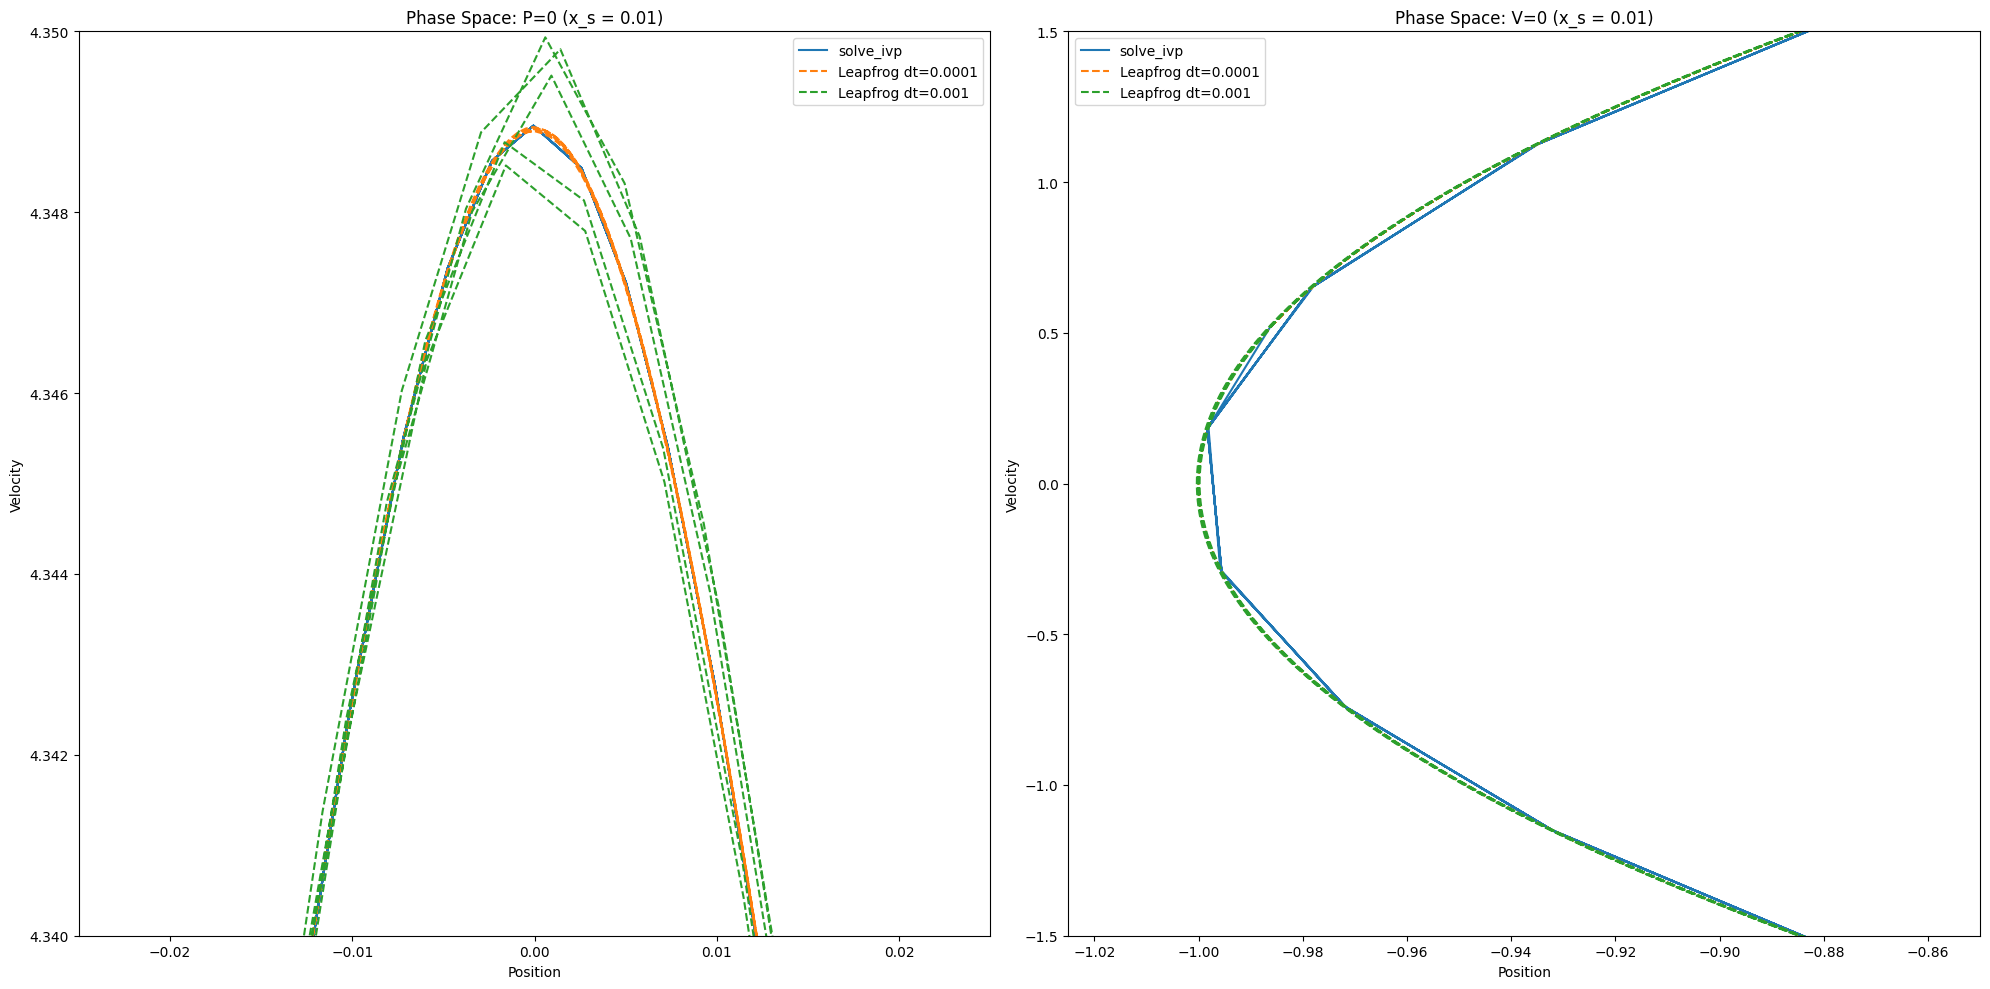

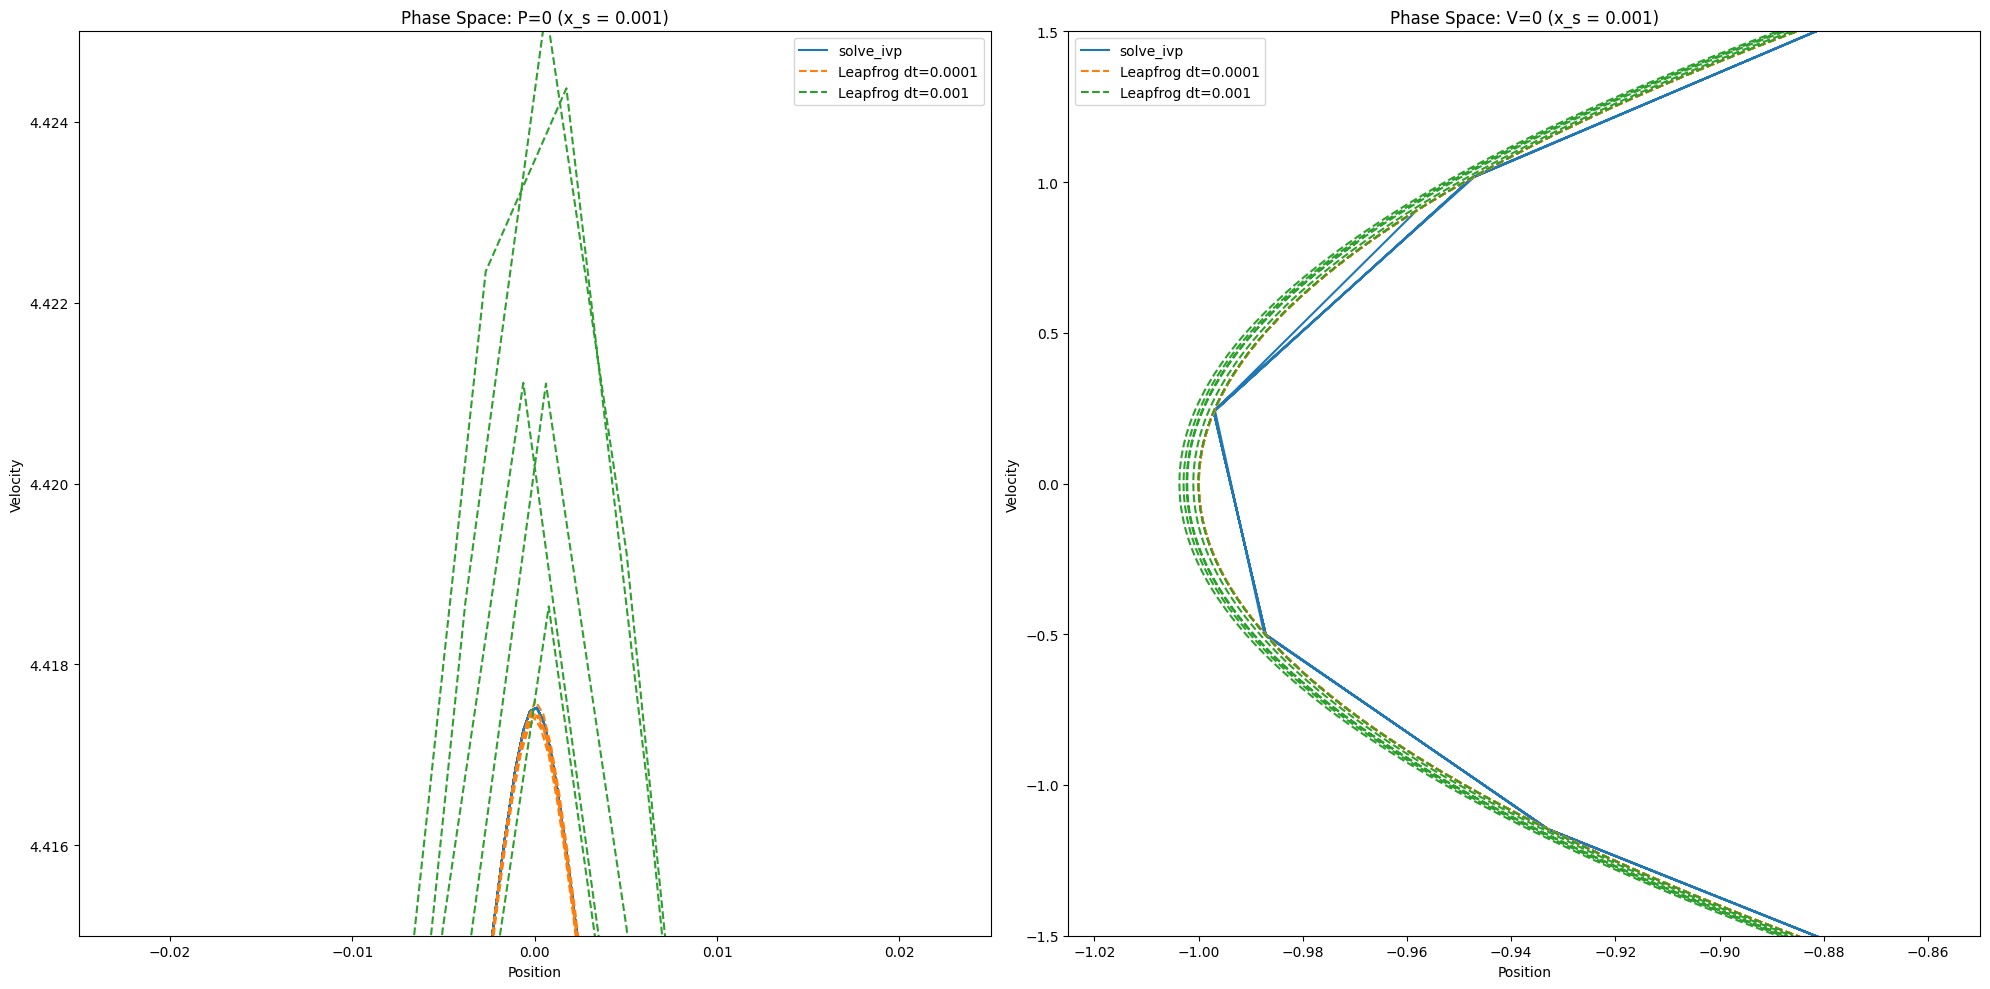

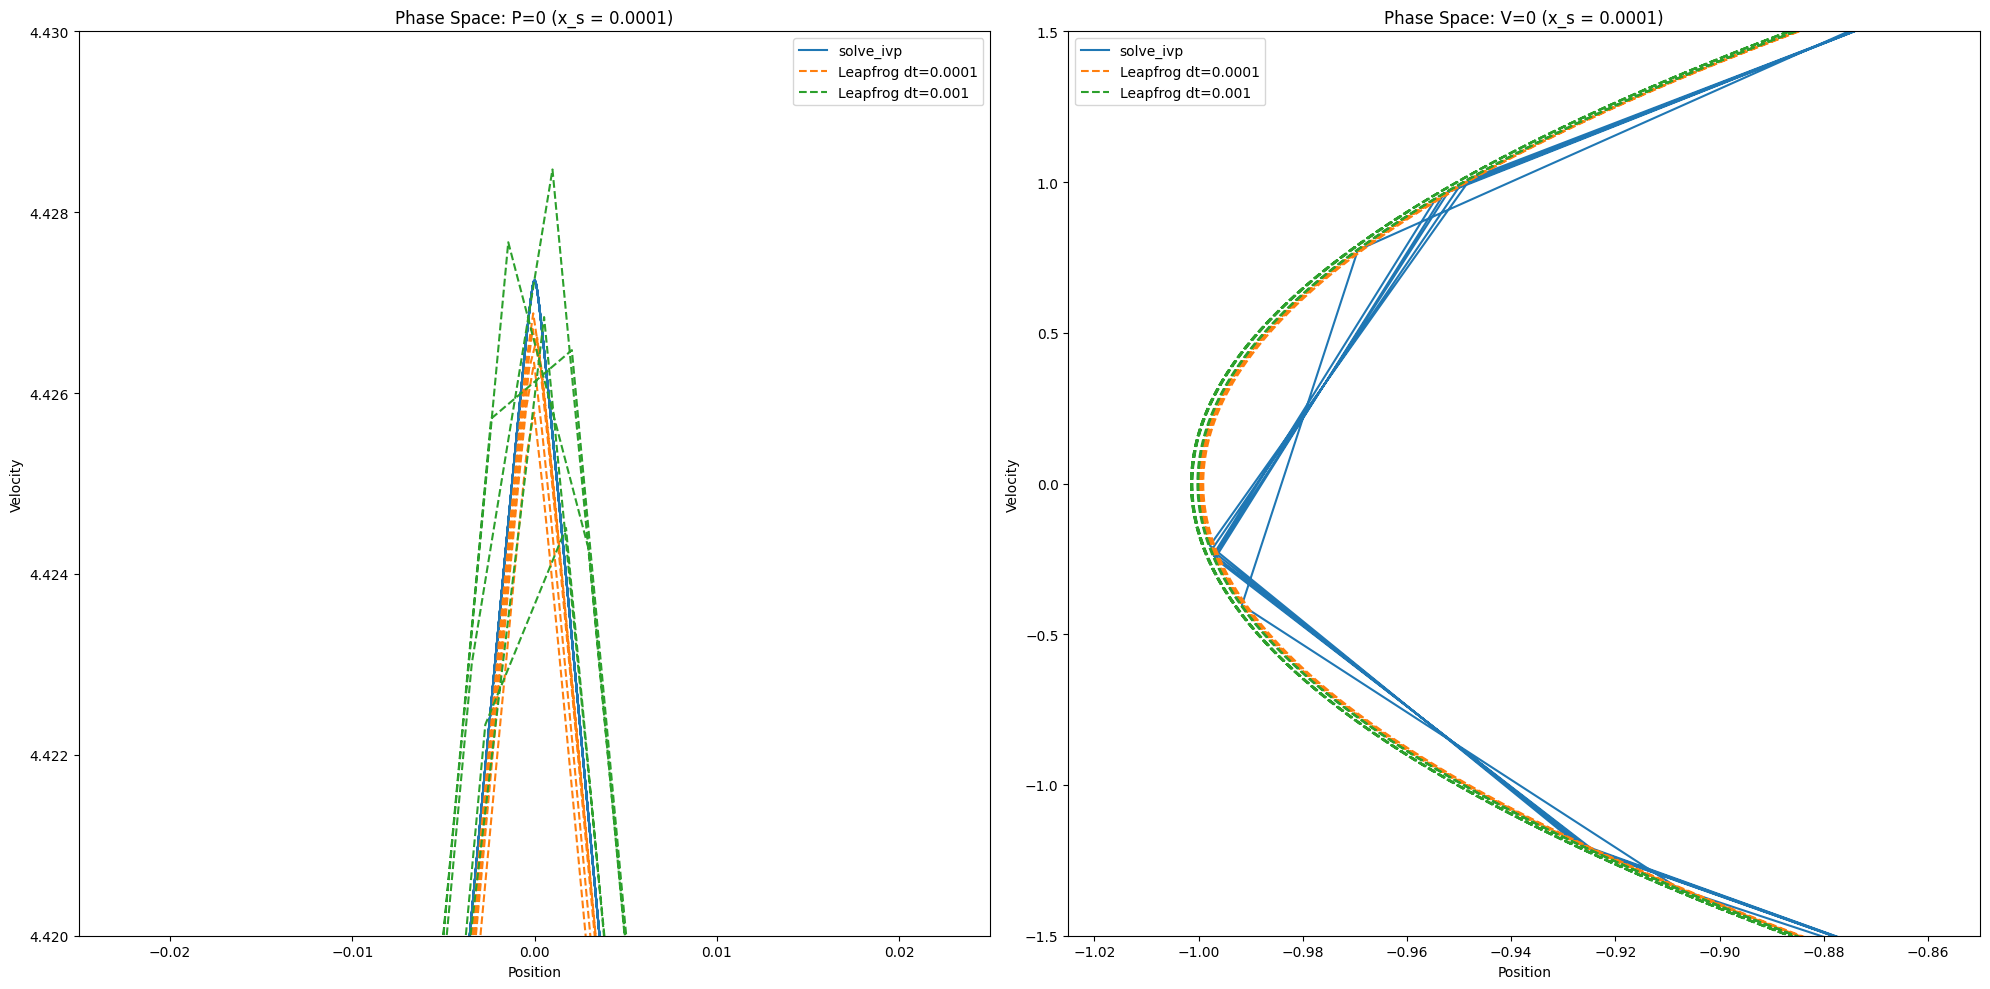

In [7]:
# Parameters
orbits = 5
x0 = 1
v0 = 0
T = 2 * np.pi * np.sqrt(x0/const.g)  # Time Orbit

def force(x, x_s):
    return -const.g * 2 / np.pi * np.arctan(x / x_s)

def total_energy(x, v, x_s):
    potential = -const.g / np.pi * (np.log(x**2 + x_s**2) * x_s - 2 * x * np.arctan(x/x_s))
    kinetic = 0.5 * v**2
    return kinetic + potential

def system(t, y, x_s):
    x, v = y
    return [v, force(x, x_s)]

def numerical_solution(x0, v0, x_s, dt, T, orbits):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    
    x = np.zeros(h)
    v = np.zeros(h)
    x[0] = x0
    v[0] = v0
    

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force(x[i],x_s)
        x[i+1] = x[i] + dt * v[i+1]
        if x[i] * x[i+1] < 0:
            v_half = v[i] + dt * 0.5 * force(x[i],x_s)
            v_b = v[i] + (-x[i]/v_half) * force(x[i],x_s)
            x[i+1] = x[i] + v_half * dt
            v[i+1] = v_b + ((x[i]/v_half) + dt) * force(x[i+1],x_s)
        else:
            v[i+1] = v[i+1] + 0.5 * dt * force(x[i+1],x_s)

    
    return t, x, v

def ivp_solution(x0, v0, x_s, T, orbits):
    t_span = (0, orbits * T)
    y0 = [x0, v0]
    sol = solve_ivp(system, t_span, y0, args=(x_s,), method='RK45', rtol=1e-10, atol=1e-10)
    return sol.t, sol.y[0], sol.y[1]

p0_ylims = {
    1:(2.335,2.345),
    0.1: (3.93, 3.94),
    0.01: (4.34, 4.35),
    0.001: (4.415, 4.425),
    0.0001: (4.42, 4.430)} 

def generate_plots(x_s):
    # Compute solutions
    t_ivp, x_ivp, v_ivp = ivp_solution(x0, v0, x_s, T, orbits)
    stepsizes = [1e-4, 1e-3]
    leapfrog_results = [numerical_solution(x0, v0, x_s, dt, T, orbits) for dt in stepsizes]
   
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot 1: P=0
    ax1.plot(x_ivp, v_ivp, label='solve_ivp')
    for i, (_, x, v) in enumerate(leapfrog_results):
        ax1.plot(x, v, label=f'Leapfrog dt={stepsizes[i]}', linestyle='--')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Velocity')
    ax1.set_xlim(-0.025, 0.025)
    ax1.set_ylim(p0_ylims[x_s])
    ax1.set_title(f'Phase Space: P=0 (x_s = {x_s})')
    ax1.legend()
    
    # Plot 2: V=0
    ax2.plot(x_ivp, v_ivp, label='solve_ivp')
    for i, (_, x, v) in enumerate(leapfrog_results):
        ax2.plot(x, v, label=f'Leapfrog dt={stepsizes[i]}', linestyle='--')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Velocity')
    ax2.set_xlim(-1.025, -0.85)
    ax2.set_ylim(-1.5, 1.5)
    ax2.set_title(f'Phase Space: V=0 (x_s = {x_s})')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Generate plots for multiple x_s values
x_s_values = [1,0.1, 0.01, 0.001, 0.0001]

for x_s in x_s_values:
    generate_plots(x_s)

In [5]:
# Parameters
orbits = 10
x0 = 1
v0 = 0
T = 2 * np.pi * np.sqrt(x0/const.g) 
x_s = 0.001

# Force and energy functions
def create_force_arctan(x_s):
    return lambda x: -const.g * 2/np.pi * np.arctan(x/x_s)

def create_force_abs():
    return lambda x: -const.g * np.sign(x)

force_arctan = create_force_arctan(x_s)
force_abs = create_force_abs()

def total_energy_arctan(x, v, x_s):
    potential = 2*const.g / np.pi * ( x *np.arctan(x/x_s) - 0.5 * x_s * np.log(x**2 + x_s**2))
    #potential = -2 * const.g/(np.pi * (1 + x**2/x_s**2) * x_s)
    kinetic = 0.5 * v**2
    return kinetic + potential

def total_energy_abs(x, v):
    potential = const.g * np.abs(x)
    kinetic = 0.5 * v**2
    return kinetic + potential

# System functions for solve_ivp
def system_arctan(t, y):
    x, v = y
    return [v, force_arctan(x)]

def system_abs(t, y):
    x, v = y
    return [v, force_abs(x)]

def analyze_bounce_dynamics(x0, v0, x_s, force_fn, dt, T, orbits, force_type="arctan", method="standard"):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    
    bounce_data = []
    x = np.zeros(h)
    v = np.zeros(h)
    x[0] = x0
    v[0] = v0
    
    if force_type == "arctan":
        energy_fn = lambda x, v: total_energy_arctan(x, v, x_s)
    else:
        energy_fn = lambda x, v: total_energy_abs(x, v)
    
    bounce_count = 0
    
def analyze_bounce_dynamics(x0, v0, x_s, force_fn, dt, T, orbits, force_type="arctan", method="standard"):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    
    bounce_data = []
    x = np.zeros(h)
    v = np.zeros(h)
    x[0] = x0
    v[0] = v0
    
    if force_type == "arctan":
        energy_fn = lambda x, v: total_energy_arctan(x, v, x_s)
    else:
        energy_fn = lambda x, v: total_energy_abs(x, v)
    
    bounce_count = 0
    
    for i in range(h-1):
        
        # First half of leapfrog
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]

        # Store initial state before any updates
        x_pre = x[i]
        v_pre = v[i]
        e_original = energy_fn(x_pre, v_pre)

        # Check for bounce
        if x[i] * x[i+1] < 0:
            if method == "standard":
                # Standard leapfrog completion
                v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])
                e_final = energy_fn(x[i+1], v[i+1])
            
            elif method == "timestep":
                # Modified timestep method
                delta_t1 = -x_pre/v[i+1]  # Using velocity after first half-step
                delta_t2 = dt - delta_t1
                v[i+1] = v_pre + force_fn(x_pre) * delta_t1
                x[i+1] = x_pre + v[i+1] * dt
                
                # Calculate final energy before last velocity update
                e_final = energy_fn(x[i+1], v[i+1])
                v[i+1] = v[i+1] + force_fn(x[i+1]) * delta_t2

            elif method == "velocity":
                # Velocity correction method
                v_half = v[i] + dt * 0.5 * force_fn(x[i])
                v_b = v[i] + (-x[i]/v_half) * force_fn(x[i])
                x[i+1] = x[i] + v_half * dt
                
                # Calculate final energy before last velocity update
                e_final = energy_fn(x[i+1], v_b)
                v[i+1] = v_b + ((x_pre/v_half) + dt) * force_fn(x[i+1])  # eq 10

            # Record bounce data - only at actual bounce points
            bounce_count += 1
            if bounce_count <= 10:
                data = {
                    'bounce': bounce_count,
                    'dx': x[i+1] - x_pre,
                    'dv': v[i+1] - v_pre,
                    'dE': e_final - e_original,
                    'method': method,
                    'dt': dt
                }
                bounce_data.append(data)
                    
        else:
            # Standard leapfrog completion for non-bounce steps
            v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])
            
    return pd.DataFrame(bounce_data)

def format_summary(results_dict, force_type, dt):
    print(f"\nAnalysis for {force_type}_dt_{dt}:")    
    # Header row with method names
    print("       |{:^44}|{:^44}|{:^44}|".format(
        "Standard Method", 
        "Modified Timestep Method",
        "Velocity Correction Method", 
        ))
    print("       |" + "-" * 44 + "|" + "-" * 44 + "|" + "-" * 44 + "|")
    print("       |{:>15}{:>15}{:>14}|{:>15}{:>15}{:>14}|{:>15}{:>15}{:>14}|".format(
        "dx", "dv", "dE",
        "dx", "dv", "dE",
        "dx", "dv", "dE",
        ))
    print("       |" + "-" * 44 + "|" + "-" * 44 + "|" + "-" * 44 + "|")
    
    def format_num(x):
        return f"{x:14.6e}"
    
    for bounce in range(1, 11):
        std_data = results_dict['standard'][results_dict['standard']['bounce'] == bounce].iloc[0] if bounce <= len(results_dict['standard']) else None
        time_data = results_dict['timestep'][results_dict['timestep']['bounce'] == bounce].iloc[0] if bounce <= len(results_dict['timestep']) else None
        vel_data = results_dict['velocity'][results_dict['velocity']['bounce'] == bounce].iloc[0] if bounce <= len(results_dict['velocity']) else None
        
        if all(data is not None for data in [std_data, time_data, vel_data]):
            print(f"{int(std_data['bounce']):6d} |"
                  f"{format_num(std_data['dx'])} {format_num(std_data['dv'])} {format_num(std_data['dE'])}|"
                  f"{format_num(time_data['dx'])} {format_num(time_data['dv'])} {format_num(time_data['dE'])}|"
                  f"{format_num(vel_data['dx'])} {format_num(vel_data['dv'])} {format_num(vel_data['dE'])}|"
                )
    print("\n")

# Force functions
force_arctan = create_force_arctan(x_s)
force_abs = create_force_abs()

# Stepsizes
stepsizes = [1e-4]
results = {}

for dt in stepsizes:
    for force_type, force_fn in [('arctan', force_arctan), ('abs', force_abs)]:
        results[force_type] = {}
        
        # Run all three methods
        for method in ['standard', 'timestep', 'velocity']:
            results[force_type][method] = analyze_bounce_dynamics(
                x0, v0, x_s, force_fn, dt, T, orbits, force_type, method
            )
        
        # Format and display results
        format_summary(results[force_type], force_type, dt)


Analysis for arctan_dt_0.0001:
       |              Standard Method               |          Modified Timestep Method          |         Velocity Correction Method         |
       |--------------------------------------------|--------------------------------------------|--------------------------------------------|
       |             dx             dv            dE|             dx             dv            dE|             dx             dv            dE|
       |--------------------------------------------|--------------------------------------------|--------------------------------------------|
     1 | -4.417506e-04   1.295096e-04   1.710717e-05| -4.417506e-04   2.590406e-04   5.892103e-04| -4.417506e-04   2.590406e-04   5.892103e-04|
     2 |  4.417506e-04  -1.288324e-04   1.703109e-05|  4.417450e-04   1.276233e-04   3.582114e-04|  4.417403e-04   1.276240e-04   3.582080e-04|
     3 | -4.417507e-04   1.281550e-04   1.695477e-05| -4.417492e-04  -5.920970e-05   3.112209e-04| -4.41

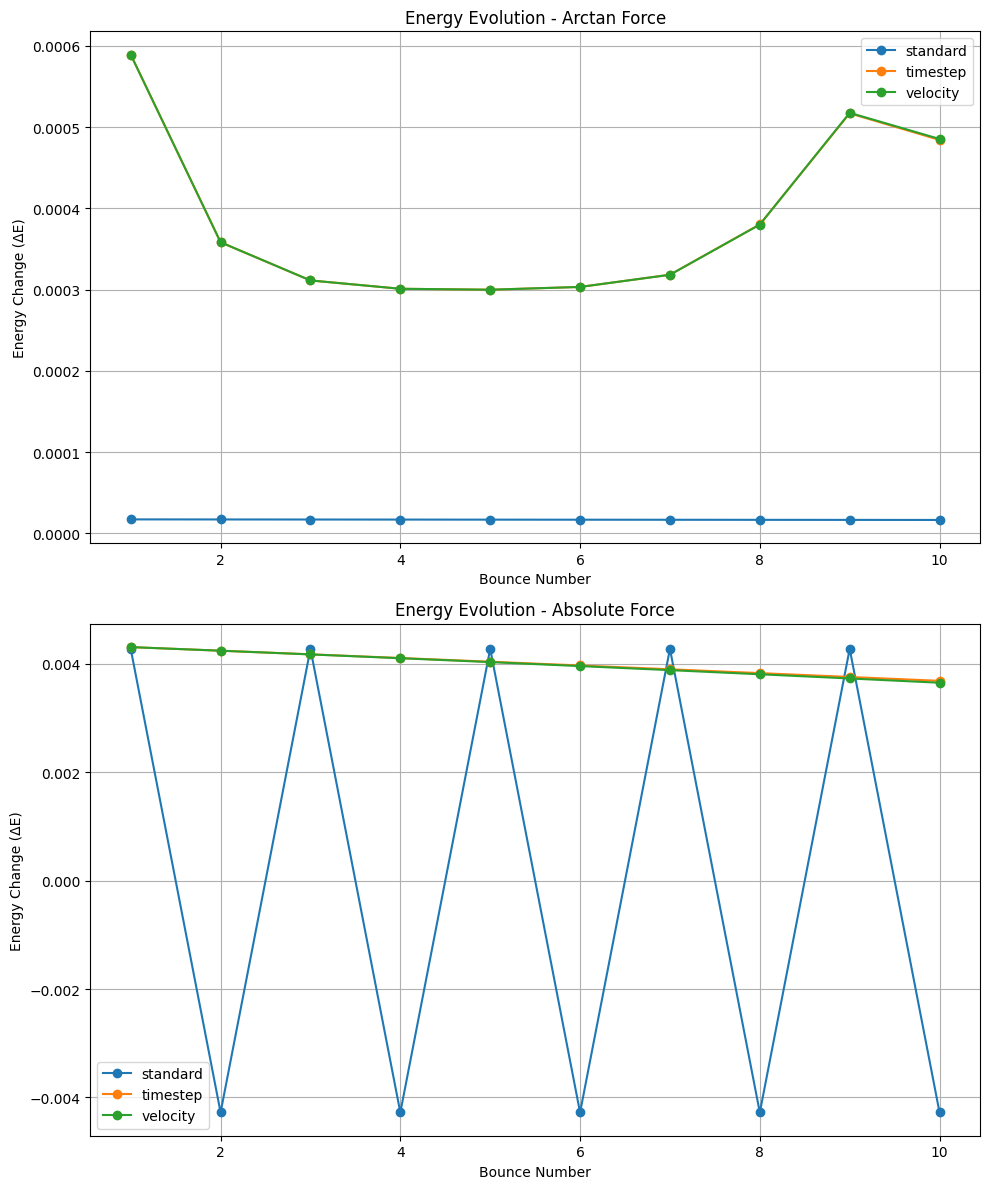

In [17]:
def plot_energy_comparison(results_dict):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot for arctan force
    for method in ['standard', 'timestep', 'velocity']:
        energy_data = results_dict['arctan'][method]['dE'].values
        ax1.plot(range(1, len(energy_data) + 1), energy_data, label=method, marker='o')
    
    ax1.set_title('Energy Evolution - Arctan Force')
    ax1.set_xlabel('Bounce Number')
    ax1.set_ylabel('Energy Change (ΔE)')
    ax1.grid(True)
    ax1.legend()
    
    # Plot for abs force
    for method in ['standard', 'timestep', 'velocity']:
        energy_data = results_dict['abs'][method]['dE'].values
        ax2.plot(range(1, len(energy_data) + 1), energy_data, label=method, marker='o')
    
    ax2.set_title('Energy Evolution - Absolute Force')
    ax2.set_xlabel('Bounce Number')
    ax2.set_ylabel('Energy Change (ΔE)')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# After running your simulations:
plot_energy_comparison(results)

In [2]:
# Force and energy functions
def create_force_arctan(x_s):
    return lambda x: -const.g * 2/np.pi * np.arctan(x/x_s)

def create_force_abs():
    return lambda x: -const.g * np.sign(x)

def calc_energy_arctan(x,v,x_s):
    return 0.5 * v**2 + 2 * const.g/np.pi * (x * np.arctan(x/x_s) - 0.5 * x_s * np.log(x**2 + x_s**2))

def calc_energy_abs(x,v):
    return 0.5 * v**2 + const.g * np.abs(x)

def standard_integrator(x0,v0,force_fn,dt, h):   
    # Arrays
    x = np.zeros(h)
    v = np.zeros(h) 
    x[0] = x0
    v[0] = v0

    for i in range(h-1):
            # Standard leapfrog step for all methods
            v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
            x[i+1] = x[i] + dt * v[i+1]
            v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])
    
    return x, v

def timestep_integrator(x0,v0,force_fn,dt,h):    
    #Arrays
    x = np.zeros(h)
    v = np.zeros(h) 
    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]

        x_pre = x[i]
        v_pre = v[i]
        if x[i] * x[i+1] < 0:
            delta_t1 = -x_pre/v[i+1]
            delta_t2 = dt - delta_t1
            v[i+1] = v_pre + force_fn(x_pre) * delta_t1
            x[i+1] = x_pre + v[i+1] * dt
            v[i+1] = v[i+1] + force_fn(x[i+1]) * delta_t2

        else:
           v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1]) 

    return x,v

def velocity_integrator(x0,v0,force_fn,dt,h):
    # Arrays
    x = np.zeros(h)
    v = np.zeros(h) 
    x[0] = x0
    v[0] = v0
    
    for i in range(h-1):
        # Standard leapfrog step for all methods
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]

        #Check for bounce
        if x[i] * x[i+1] < 0:
            v_half = v[i] + dt * 0.5 * force_fn(x[i])
            v_b = v[i] + (-x[i]/v_half) * force_fn(x[i])
            x[i+1] = x[i] + v_half * dt
            v[i+1] = v_b + ((x[i]/v_half) + dt) * force_fn(x[i+1])

        else:
            v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])

    return x,v


In [8]:
def plot_energy_conservation(dt, x_s):
    #Parameters
    orbits = 10
    x0 = 1
    v0 = 0
    T = 2 * np.pi * np.sqrt(x0/const.g)

    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)

    force_arctan = create_force_arctan(x_s)
    force_abs = create_force_abs()

    results = {}
    for force_type in ['arctan', 'abs']:
        force_fn = force_arctan if force_type == 'arctan' else force_abs
        energy_fn = calc_energy_arctan if force_type == 'arctan' else calc_energy_abs

        #Standard Leapfrog
        x_std, v_std = standard_integrator(x0, v0, force_fn, dt, h)
        standard_energy = energy_fn(x_std, v_std, x_s) if force_type == 'arctan' else energy_fn(x_std, v_std)
        #Timestep Modfied Leapfrog
        x_ts, v_ts = timestep_integrator(x0, v0, force_fn, dt, h)
        timestep_energy = energy_fn(x_ts, v_ts, x_s) if force_type == 'arctan' else energy_fn(x_ts, v_ts)
        #Velocity Modified Leapfrog
        x_vel, v_vel = velocity_integrator(x0, v0, force_fn, dt, h)
        velocity_energy = energy_fn(x_vel, v_vel, x_s) if force_type == 'arctan' else energy_fn(x_vel, v_vel)

        results[force_type] = {
            'standard': standard_energy,
            'timestep': timestep_energy,
            'velocity': velocity_energy,
            't': t
        }

        #Plot
    plt.figure(figsize=(16, 10))

    plt.subplot(1,2,1)
    plt.plot(t, results['arctan']['standard'], label = 'Standard Energy')
    plt.plot(t, results['arctan']['timestep'], label = 'Timestep Energy')
    plt.plot(t, results['arctan']['velocity'], label = 'Velocity Energy')
    plt.xlabel('Time')
    # plt.xlim(0,10)
    plt.ylabel('Energy')
    plt.title('Arctan Force')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(t, results['abs']['standard'], label = 'Standard Energy')
    plt.plot(t, results['abs']['timestep'], label = 'Timestep Energy')
    plt.plot(t, results['abs']['velocity'], label = 'Velocity Energy')
    plt.xlabel('Time')
    # plt.xlim(0,10)
    plt.ylabel('Energy')
    plt.yscale('log')
    plt.title('Abs Force')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

dt_slider = FloatLogSlider(
    value=1e-4,
    base=10,
    min=-4, 
    max=0,  
    step=1, 
    description='dt:',
    readout_format='.1e'
)

x_s_slider = FloatLogSlider(
    value=1e-3,
    base=10,
    min=-3,  
    max=1, 
    step=1,  
    description='x_s:',
    readout_format='.1e'
)

# Create interactive plot
interactive_plot = wd.interactive(plot_energy_conservation, dt=dt_slider, x_s=x_s_slider)

# Display the interactive plot
display(interactive_plot)

interactive(children=(FloatLogSlider(value=0.0001, description='dt:', max=0.0, min=-4.0, readout_format='.1e',…

Energy conservation plots generated and saved.


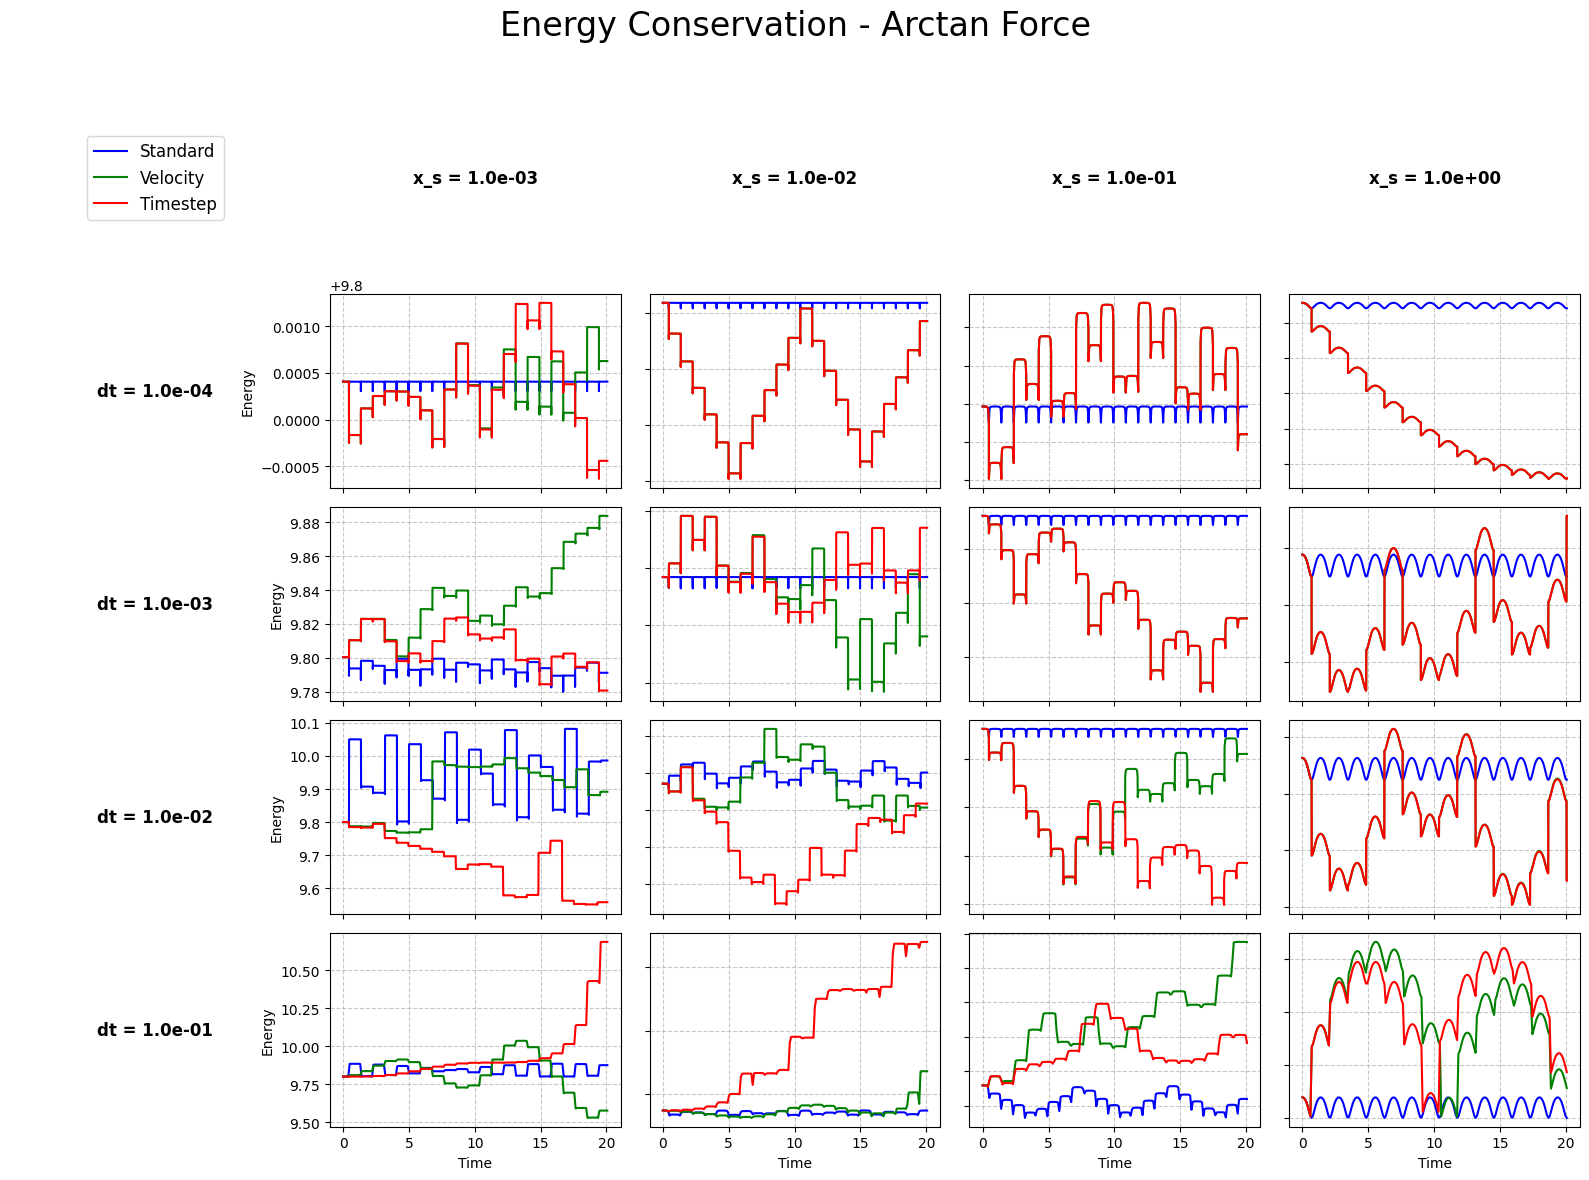

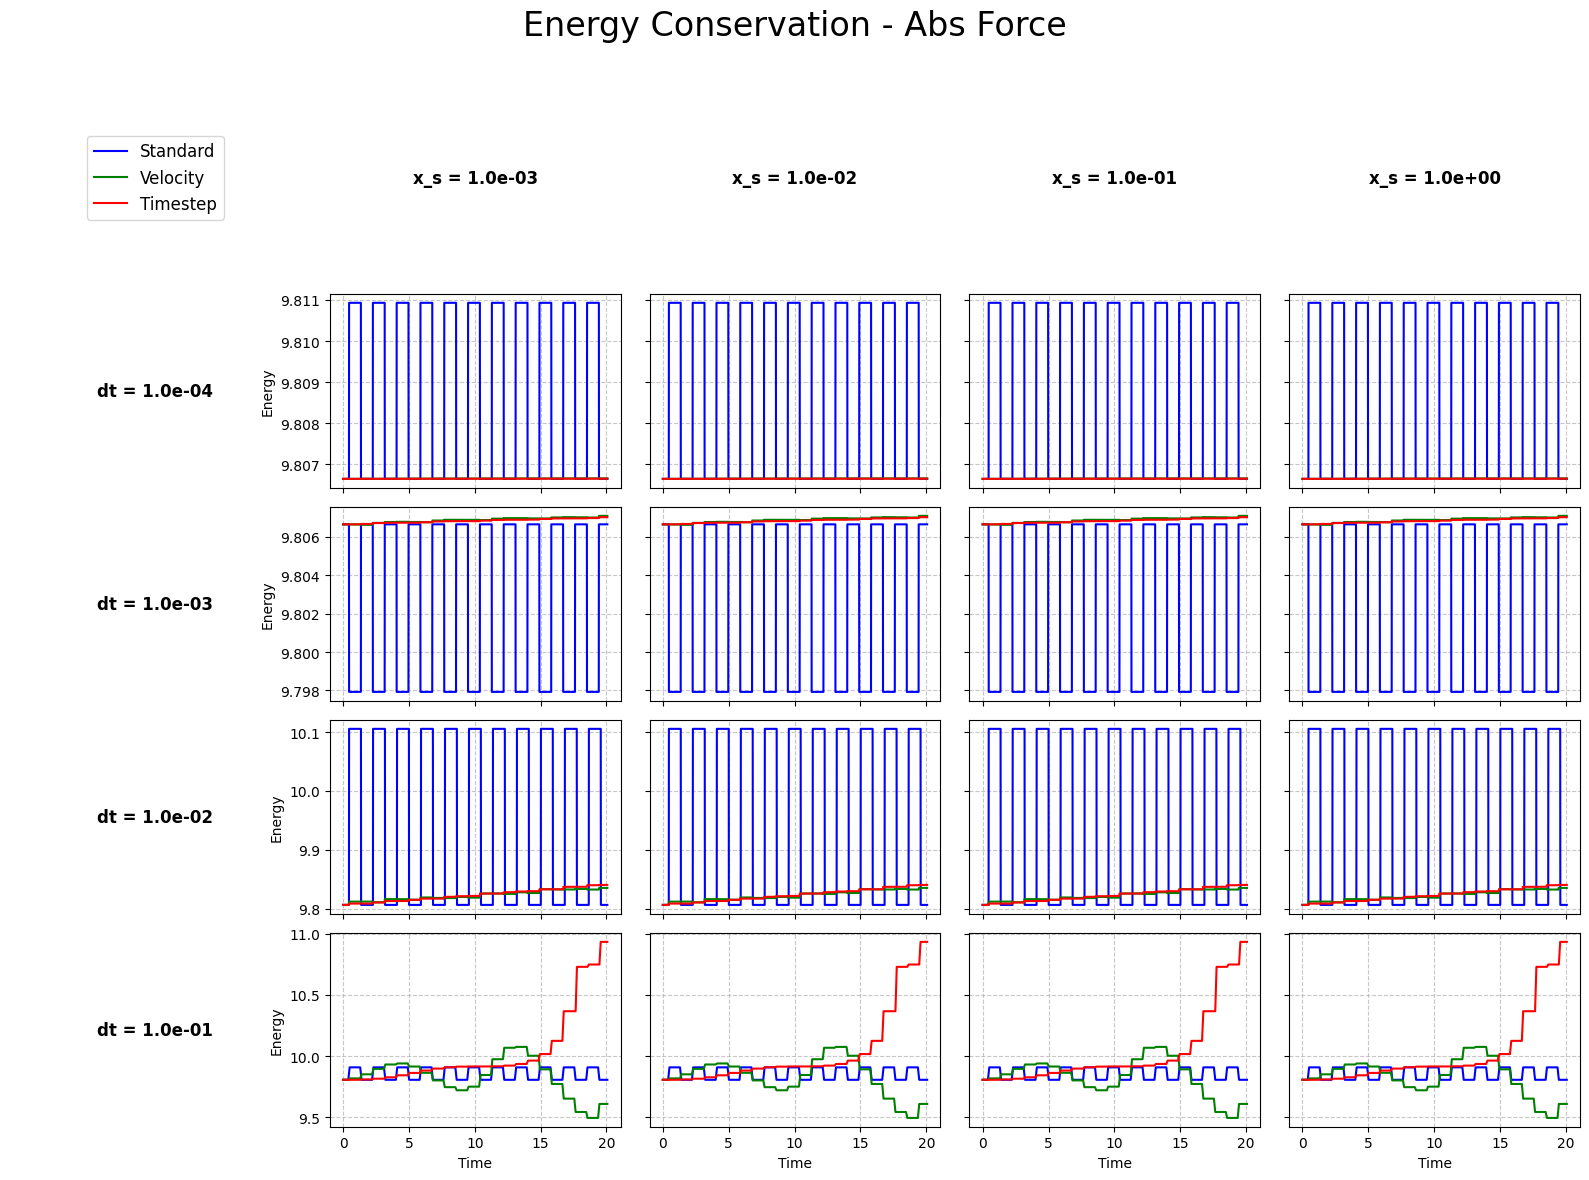

In [13]:
from matplotlib.gridspec import GridSpec

# Force and energy functions
def create_force_arctan(x_s):
    return lambda x: -const.g * 2/np.pi * np.arctan(x/x_s)

def create_force_abs():
    return lambda x: -const.g * np.sign(x)

def calc_energy_arctan(x, v, x_s):
    return 0.5 * v**2 + 2 * const.g/np.pi * (x * np.arctan(x/x_s) - 0.5 * x_s * np.log(x**2 + x_s**2))

def calc_energy_abs(x, v):
    return 0.5 * v**2 + const.g * np.abs(x)

# Integration methods
def standard_integrator(x0, v0, force_fn, dt, h):   
    x = np.zeros(h)
    v = np.zeros(h) 
    x[0] = x0
    v[0] = v0
    
    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])
    
    return x, v

def timestep_integrator(x0, v0, force_fn, dt, h):    
    x = np.zeros(h)
    v = np.zeros(h) 
    x[0] = x0
    v[0] = v0
    
    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        x_pre = x[i]
        v_pre = v[i]
        
        if x[i] * x[i+1] < 0:
            delta_t1 = -x_pre/v[i+1]
            delta_t2 = dt - delta_t1
            v[i+1] = v_pre + force_fn(x_pre) * delta_t1
            x[i+1] = x_pre + v[i+1] * dt
            v[i+1] = v[i+1] + force_fn(x[i+1]) * delta_t2
        else:
           v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1]) 
    
    return x, v

def velocity_integrator(x0, v0, force_fn, dt, h):
    x = np.zeros(h)
    v = np.zeros(h) 
    x[0] = x0
    v[0] = v0
    
    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        
        if x[i] * x[i+1] < 0:
            v_half = v[i] + dt * 0.5 * force_fn(x[i])
            v_b = v[i] + (-x[i]/v_half) * force_fn(x[i])
            x[i+1] = x[i] + v_half * dt
            v[i+1] = v_b + ((x[i]/v_half) + dt) * force_fn(x[i+1])
        else:
            v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])
    
    return x, v

# Function to generate improved energy conservation plots
def plot_energy_conservation(dt_values, x_s_values, force_type):
    # Create a figure with GridSpec for better control
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(len(dt_values)+1, len(x_s_values)+1, figure=fig)
    
    # Add a main title
    fig.suptitle(f'Energy Conservation - {force_type.capitalize()} Force', fontsize=24)
    
    # Add column headers (x_s values)
    for j, x_s in enumerate(x_s_values):
        ax = fig.add_subplot(gs[0, j+1])
        ax.text(0.5, 0.5, f'x_s = {x_s:.1e}', ha='center', va='center', fontsize=12, fontweight='bold')
        ax.axis('off')
    
    # Add row headers (dt values)
    for i, dt in enumerate(dt_values):
        ax = fig.add_subplot(gs[i+1, 0])
        ax.text(0.5, 0.5, f'dt = {dt:.1e}', ha='center', va='center', fontsize=12, fontweight='bold')
        ax.axis('off')
    
    # Parameters
    orbits = 10
    x0 = 1
    v0 = 0
    
    # Create a shared legend at the top
    legend_ax = fig.add_subplot(gs[0, 0])
    legend_ax.plot([], [], 'b-', label='Standard')
    legend_ax.plot([], [], 'g-', label='Velocity')
    legend_ax.plot([], [], 'r-', label='Timestep')
    legend_ax.legend(loc='center', fontsize=12)
    legend_ax.axis('off')
    
    for i, dt in enumerate(dt_values):
        for j, x_s in enumerate(x_s_values):
            # Calculate orbit time and points
            T = 2 * np.pi * np.sqrt(x0/const.g)
            t_final = orbits * T
            h = int(t_final / dt) + 1
            t = np.linspace(0, t_final, h)
            
            # Setup force and energy functions
            if force_type == 'arctan':
                force_fn = create_force_arctan(x_s)
                energy_fn = lambda x, v: calc_energy_arctan(x, v, x_s)
            else:  # 'abs'
                force_fn = create_force_abs()
                energy_fn = calc_energy_abs
            
            # Run integrators
            x_std, v_std = standard_integrator(x0, v0, force_fn, dt, h)
            x_ts, v_ts = timestep_integrator(x0, v0, force_fn, dt, h)  
            x_vel, v_vel = velocity_integrator(x0, v0, force_fn, dt, h)
            
            # Calculate energies
            std_energy = energy_fn(x_std, v_std)
            ts_energy = energy_fn(x_ts, v_ts)
            vel_energy = energy_fn(x_vel, v_vel)
            
            # Plot energy conservation
            ax = fig.add_subplot(gs[i+1, j+1])
            ax.plot(t, std_energy, 'b-')
            ax.plot(t, vel_energy, 'g-')
            ax.plot(t, ts_energy, 'r-')
            
            # Only add x labels on bottom row
            if i == len(dt_values)-1:
                ax.set_xlabel('Time')
            else:
                ax.set_xticklabels([])
            
            # Only add y labels on leftmost column
            if j == 0:
                ax.set_ylabel('Energy')
            else:
                ax.set_yticklabels([])
            
            ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.1, wspace=0.1)
    
    return fig

# Define parameter ranges
dt_values = [1e-4, 1e-3, 1e-2, 1e-1]
x_s_values = [1e-3, 1e-2, 1e-1, 1e0]

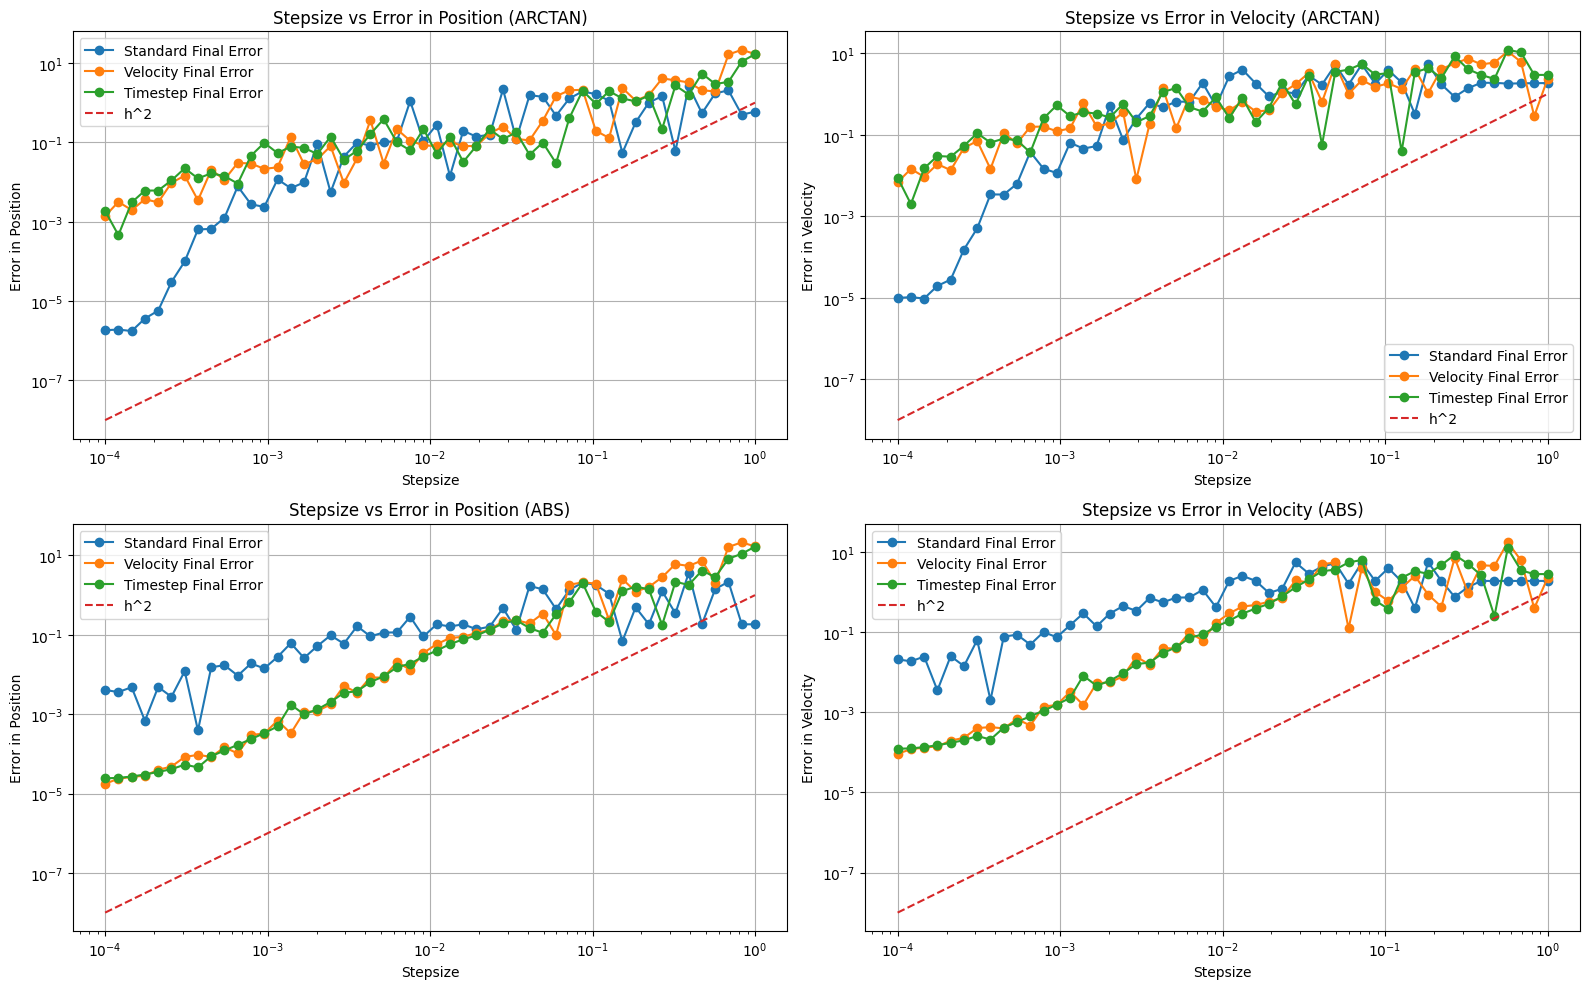

In [21]:
orbits = 10
x0 = 1
v0 = 0
x_s = 1e-3
T = 2 * np.pi * np.sqrt(x0/const.g) #Time Orbit

# Force and energy functions
def create_force_arctan(x_s):
    return lambda x: -const.g * 2/np.pi * np.arctan(x/x_s)

def create_force_abs():
    return lambda x: -const.g * np.sign(x)

force_arctan = create_force_arctan(x_s)
force_abs = create_force_abs()

#Standard Solutions
def standard_numerical_solution(x0, v0, dt, T, orbits, force_fn):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    dt = t_final/(h-1)
    #print(f"Method: {standard_numerical_solution}, h: {h}, dt: {dt}, t_final: {t_final}")
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])

    return t, x, v

def standard_estimated_analytical_solution(x0, v0, dt, T, orbits, force_fn):
    dt = 1e-6 #Reference Time Step
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])

    return t, x, v

#Velocity Corrected Solutions
def velocity_corrected_numerical_solution(x0, v0, dt, T, orbits, force_fn):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    dt = t_final/(h-1)
    #print(f"Method: {velocity_corrected_numerical_solution}, h: {h}, dt: {dt}, t_final: {t_final}")
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        if x[i] * x[i+1] < 0:
            v_half = v[i] + dt * 0.5 * force_fn(x[i])
            v_b = v[i] + (-x[i]/v_half) * force_fn(x[i])
            x[i+1] = x[i] + v_half * dt
            v[i+1] = v_b + ((x[i]/v_half) + dt) * force_fn(x[i+1])

        else:
            v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])

    return t, x, v

#Timestep Corrected Solutions
def timestep_corrected_numerical_solution(x0, v0, dt, T, orbits, force_fn):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    dt = t_final/(h-1)
    #print(f"Method: {timestep_corrected_numerical_solution}, h: {h}, dt: {dt}, t_final: {t_final}")
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
       
        x_pre = x[i]
        v_pre = v[i]
        if x[i] * x[i+1] < 0:
            delta_t1 = -x_pre/v[i+1]
            delta_t2 = dt - delta_t1
            v[i+1] = v_pre + force_fn(x_pre) * delta_t1
            x[i+1] = x_pre + v[i+1] * dt
            v[i+1] = v[i+1] + force_fn(x[i+1]) * delta_t2

        else:
           v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1]) 

    return t, x, v

def find_closest_index(t_ref, t_target):
    # Find the index in t_ref that is closest to each value in t_target.
    return np.searchsorted(t_ref, t_target)

#Error Calculation
def calculate_error(stepsizes, force_fn):

    #Analytical Solution
    estimated_t, estimated_x, estimated_v = standard_estimated_analytical_solution(x0, v0, None, T, orbits, force_fn)

    std_final_error_position = []
    std_final_error_velocity = []
    std_rms_error_position = []
    std_rms_error_velocity = []

    velocity_final_error_position = []
    velocity_final_error_velocity = []
    velocity_rms_error_position = []
    velocity_rms_error_velocity = []

    timestep_final_error_position = []
    timestep_final_error_velocity = []
    timestep_rms_error_position = []
    timestep_rms_error_velocity = []

    for dt in stepsizes:
        #Numerical Solutions
        t_std, x_std, v_std = standard_numerical_solution(x0, v0, dt, T, orbits, force_fn)
        t_vel, x_vel, v_vel = velocity_corrected_numerical_solution(x0, v0, dt, T, orbits, force_fn)
        t_ts, x_ts, v_ts = timestep_corrected_numerical_solution(x0, v0, dt, T, orbits, force_fn)

        #Closest Indices
        std_idx = find_closest_index(estimated_t, t_std)
        vel_idx = find_closest_index(estimated_t, t_vel)
        ts_idx = find_closest_index(estimated_t, t_ts)

        #Error Calculations
        std_final_error_position.append(np.abs(estimated_x[std_idx] - x_std)[-1])
        std_rms_error_position.append(np.sqrt(np.mean((estimated_x[std_idx] - x_std)**2)))
        std_final_error_velocity.append(np.abs(estimated_v[std_idx] - v_std)[-1])
        std_rms_error_velocity.append(np.sqrt(np.mean((estimated_v[std_idx] - v_std)**2)))
        velocity_final_error_position.append(np.abs(estimated_x[vel_idx] - x_vel)[-1])
        velocity_rms_error_position.append(np.sqrt(np.mean((estimated_x[vel_idx] - x_vel)**2)))
        velocity_final_error_velocity.append(np.abs(estimated_v[vel_idx] - v_vel)[-1])
        velocity_rms_error_velocity.append(np.sqrt(np.mean((estimated_v[vel_idx] - v_vel)**2)))
        timestep_final_error_position.append(np.abs(estimated_x[ts_idx] - x_ts)[-1])
        timestep_rms_error_position.append(np.sqrt(np.mean((estimated_x[ts_idx] - x_ts)**2)))
        timestep_final_error_velocity.append(np.abs(estimated_v[ts_idx] - v_ts)[-1])
        timestep_rms_error_velocity.append(np.sqrt(np.mean((estimated_v[ts_idx] - v_ts)**2)))

    return {
        'standard': {
            'position': {'final':std_final_error_position, 'rms':std_rms_error_position},
            'velocity': {'final':std_final_error_velocity, 'rms':std_rms_error_velocity}},
        'velocity': {
            'position': {'final':velocity_final_error_position, 'rms':velocity_rms_error_position},
            'velocity': {'final':velocity_final_error_velocity, 'rms':velocity_rms_error_velocity}},
        'timestep': {
            'position': {'final':timestep_final_error_position, 'rms':timestep_rms_error_position}, 
            'velocity': {'final':timestep_final_error_velocity, 'rms':timestep_rms_error_velocity}}}

stepsizes = np.logspace(-4,0,50)

results = {
    'arctan': calculate_error(stepsizes, force_arctan),
    'abs': calculate_error(stepsizes, force_abs)
}

#Plotting
plt.figure(figsize=(16,10))

plt.subplot(2, 2, 1)
for method in ['standard', 'velocity', 'timestep']:
    plt.plot(stepsizes, results['arctan'][method]['position']['final'], 
             marker='o', label=f'{method.capitalize()} Final Error')
    #plt.plot(stepsizes, results['arctan'][method]['position']['rms'], 
            # marker='o', label=f'{method.capitalize()} RMS Error')
plt.plot(stepsizes, np.array(stepsizes)**2, linestyle='dashed', label='h^2')
plt.xlabel('Stepsize')
plt.ylabel('Error in Position')
plt.title('Stepsize vs Error in Position (ARCTAN)')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()

# Arctan force velocity errors
plt.subplot(2, 2, 2)
for method in ['standard', 'velocity', 'timestep']:
    plt.plot(stepsizes, results['arctan'][method]['velocity']['final'], 
             marker='o', label=f'{method.capitalize()} Final Error')
    #plt.plot(stepsizes, results['arctan'][method]['velocity']['rms'], 
             #marker='o', label=f'{method.capitalize()} RMS Error')
plt.plot(stepsizes, np.array(stepsizes)**2, linestyle='dashed', label='h^2')
plt.xlabel('Stepsize')
plt.ylabel('Error in Velocity')
plt.title('Stepsize vs Error in Velocity (ARCTAN)')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()

# Abs force position errors
plt.subplot(2, 2, 3)
for method in ['standard', 'velocity', 'timestep']:
    plt.plot(stepsizes, results['abs'][method]['position']['final'], 
             marker='o', label=f'{method.capitalize()} Final Error')
    #plt.plot(stepsizes, results['abs'][method]['position']['rms'], 
             #marker='o', label=f'{method.capitalize()} RMS Error')
plt.plot(stepsizes, np.array(stepsizes)**2, linestyle='dashed', label='h^2')
plt.xlabel('Stepsize')
plt.ylabel('Error in Position')
plt.title('Stepsize vs Error in Position (ABS)')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()

# Abs force velocity errors
plt.subplot(2, 2, 4)
for method in ['standard', 'velocity', 'timestep']:
    plt.plot(stepsizes, results['abs'][method]['velocity']['final'], 
             marker='o', label=f'{method.capitalize()} Final Error')
    #plt.plot(stepsizes, results['abs'][method]['velocity']['rms'], 
             #marker='o', label=f'{method.capitalize()} RMS Error')
plt.plot(stepsizes, np.array(stepsizes)**2, linestyle='dashed', label='h^2')
plt.xlabel('Stepsize')
plt.ylabel('Error in Velocity')
plt.title('Stepsize vs Error in Velocity (ABS)')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()

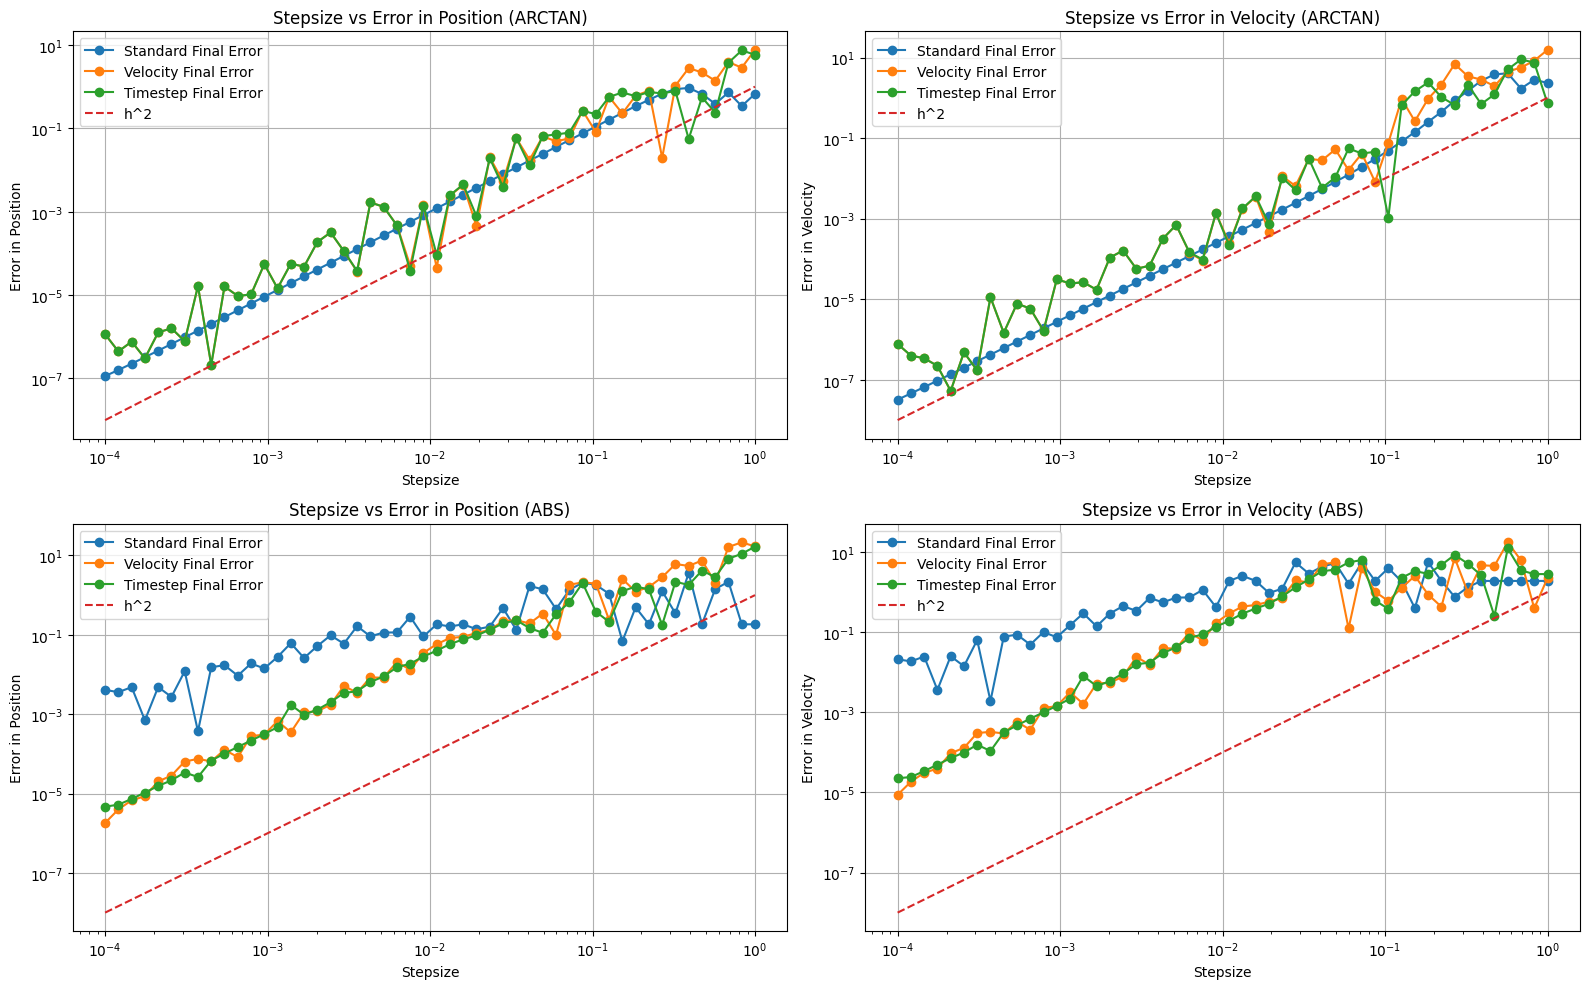

In [22]:
orbits = 10
x0 = 1
v0 = 0
x_s = 1
T = 2 * np.pi * np.sqrt(x0/const.g) #Time Orbit

# Force and energy functions
def create_force_arctan(x_s):
    return lambda x: -const.g * 2/np.pi * np.arctan(x/x_s)

def create_force_abs():
    return lambda x: -const.g * np.sign(x)

force_arctan = create_force_arctan(x_s)
force_abs = create_force_abs()

#Standard Solutions
def standard_numerical_solution(x0, v0, dt, T, orbits, force_fn):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    dt = t_final/(h-1)
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])

    return t, x, v

def standard_estimated_analytical_solution(x0, v0, dt, T, orbits, force_fn):
    dt = 1e-8 #Reference Time Step
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])

    return t, x, v

#Velocity Corrected Solutions
def velocity_corrected_numerical_solution(x0, v0, dt, T, orbits, force_fn):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    dt = t_final/(h-1)
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        if x[i] * x[i+1] < 0:
            v_half = v[i] + dt * 0.5 * force_fn(x[i])
            v_b = v[i] + (-x[i]/v_half) * force_fn(x[i])
            x[i+1] = x[i] + v_half * dt
            v[i+1] = v_b + ((x[i]/v_half) + dt) * force_fn(x[i+1])

        else:
            v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])

    return t, x, v

#Timestep Corrected Solutions
def timestep_corrected_numerical_solution(x0, v0, dt, T, orbits, force_fn):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    dt = t_final/(h-1)
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
       
        x_pre = x[i]
        v_pre = v[i]
        if x[i] * x[i+1] < 0:
            delta_t1 = -x_pre/v[i+1]
            delta_t2 = dt - delta_t1
            v[i+1] = v_pre + force_fn(x_pre) * delta_t1
            x[i+1] = x_pre + v[i+1] * dt
            v[i+1] = v[i+1] + force_fn(x[i+1]) * delta_t2

        else:
           v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1]) 

    return t, x, v

def find_closest_index(t_ref, t_target):
    # Find the index in t_ref that is closest to each value in t_target.
    return np.searchsorted(t_ref, t_target)

#Error Calculation
def calculate_error(stepsizes, force_fn):

    #Analytical Solution
    estimated_t, estimated_x, estimated_v = standard_estimated_analytical_solution(x0, v0, None, T, orbits, force_fn)

    std_final_error_position = []
    std_final_error_velocity = []
    std_rms_error_position = []
    std_rms_error_velocity = []

    velocity_final_error_position = []
    velocity_final_error_velocity = []
    velocity_rms_error_position = []
    velocity_rms_error_velocity = []

    timestep_final_error_position = []
    timestep_final_error_velocity = []
    timestep_rms_error_position = []
    timestep_rms_error_velocity = []

    for dt in stepsizes:
        #Numerical Solutions
        t_std, x_std, v_std = standard_numerical_solution(x0, v0, dt, T, orbits, force_fn)
        t_vel, x_vel, v_vel = velocity_corrected_numerical_solution(x0, v0, dt, T, orbits, force_fn)
        t_ts, x_ts, v_ts = timestep_corrected_numerical_solution(x0, v0, dt, T, orbits, force_fn)

        #Closest Indices
        std_idx = find_closest_index(estimated_t, t_std)
        vel_idx = find_closest_index(estimated_t, t_vel)
        ts_idx = find_closest_index(estimated_t, t_ts)

        #Error Calculations
        std_final_error_position.append(np.abs(estimated_x[std_idx] - x_std)[-1])
        std_rms_error_position.append(np.sqrt(np.mean((estimated_x[std_idx] - x_std)**2)))
        std_final_error_velocity.append(np.abs(estimated_v[std_idx] - v_std)[-1])
        std_rms_error_velocity.append(np.sqrt(np.mean((estimated_v[std_idx] - v_std)**2)))
        velocity_final_error_position.append(np.abs(estimated_x[vel_idx] - x_vel)[-1])
        velocity_rms_error_position.append(np.sqrt(np.mean((estimated_x[vel_idx] - x_vel)**2)))
        velocity_final_error_velocity.append(np.abs(estimated_v[vel_idx] - v_vel)[-1])
        velocity_rms_error_velocity.append(np.sqrt(np.mean((estimated_v[vel_idx] - v_vel)**2)))
        timestep_final_error_position.append(np.abs(estimated_x[ts_idx] - x_ts)[-1])
        timestep_rms_error_position.append(np.sqrt(np.mean((estimated_x[ts_idx] - x_ts)**2)))
        timestep_final_error_velocity.append(np.abs(estimated_v[ts_idx] - v_ts)[-1])
        timestep_rms_error_velocity.append(np.sqrt(np.mean((estimated_v[ts_idx] - v_ts)**2)))

    return {
        'standard': {
            'position': {'final':std_final_error_position, 'rms':std_rms_error_position},
            'velocity': {'final':std_final_error_velocity, 'rms':std_rms_error_velocity}},
        'velocity': {
            'position': {'final':velocity_final_error_position, 'rms':velocity_rms_error_position},
            'velocity': {'final':velocity_final_error_velocity, 'rms':velocity_rms_error_velocity}},
        'timestep': {
            'position': {'final':timestep_final_error_position, 'rms':timestep_rms_error_position}, 
            'velocity': {'final':timestep_final_error_velocity, 'rms':timestep_rms_error_velocity}}}

stepsizes = np.logspace(-4,0,50)

results = {
    'arctan': calculate_error(stepsizes, force_arctan),
    'abs': calculate_error(stepsizes, force_abs)
}

#Plotting
plt.figure(figsize=(16,10))

plt.subplot(2, 2, 1)
for method in ['standard', 'velocity', 'timestep']:
    plt.plot(stepsizes, results['arctan'][method]['position']['final'], 
             marker='o', label=f'{method.capitalize()} Final Error')
    #plt.plot(stepsizes, results['arctan'][method]['position']['rms'], 
             #marker='o', label=f'{method.capitalize()} RMS Error')
plt.plot(stepsizes, np.array(stepsizes)**2, linestyle='dashed', label='h^2')
plt.xlabel('Stepsize')
plt.ylabel('Error in Position')
plt.title('Stepsize vs Error in Position (ARCTAN)')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()

# Arctan force velocity errors
plt.subplot(2, 2, 2)
for method in ['standard', 'velocity', 'timestep']:
    plt.plot(stepsizes, results['arctan'][method]['velocity']['final'], 
             marker='o', label=f'{method.capitalize()} Final Error')
    #plt.plot(stepsizes, results['arctan'][method]['velocity']['rms'], 
             #marker='o', label=f'{method.capitalize()} RMS Error')
plt.plot(stepsizes, np.array(stepsizes)**2, linestyle='dashed', label='h^2')
plt.xlabel('Stepsize')
plt.ylabel('Error in Velocity')
plt.title('Stepsize vs Error in Velocity (ARCTAN)')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()

# Abs force position errors
plt.subplot(2, 2, 3)
for method in ['standard', 'velocity', 'timestep']:
    plt.plot(stepsizes, results['abs'][method]['position']['final'], 
             marker='o', label=f'{method.capitalize()} Final Error')
    #plt.plot(stepsizes, results['abs'][method]['position']['rms'], 
             #marker='o', label=f'{method.capitalize()} RMS Error')
plt.plot(stepsizes, np.array(stepsizes)**2, linestyle='dashed', label='h^2')
plt.xlabel('Stepsize')
plt.ylabel('Error in Position')
plt.title('Stepsize vs Error in Position (ABS)')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()

# Abs force velocity errors
plt.subplot(2, 2, 4)
for method in ['standard', 'velocity', 'timestep']:
    plt.plot(stepsizes, results['abs'][method]['velocity']['final'], 
             marker='o', label=f'{method.capitalize()} Final Error')
    #plt.plot(stepsizes, results['abs'][method]['velocity']['rms'], 
             #marker='o', label=f'{method.capitalize()} RMS Error')
plt.plot(stepsizes, np.array(stepsizes)**2, linestyle='dashed', label='h^2')
plt.xlabel('Stepsize')
plt.ylabel('Error in Velocity')
plt.title('Stepsize vs Error in Velocity (ABS)')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()

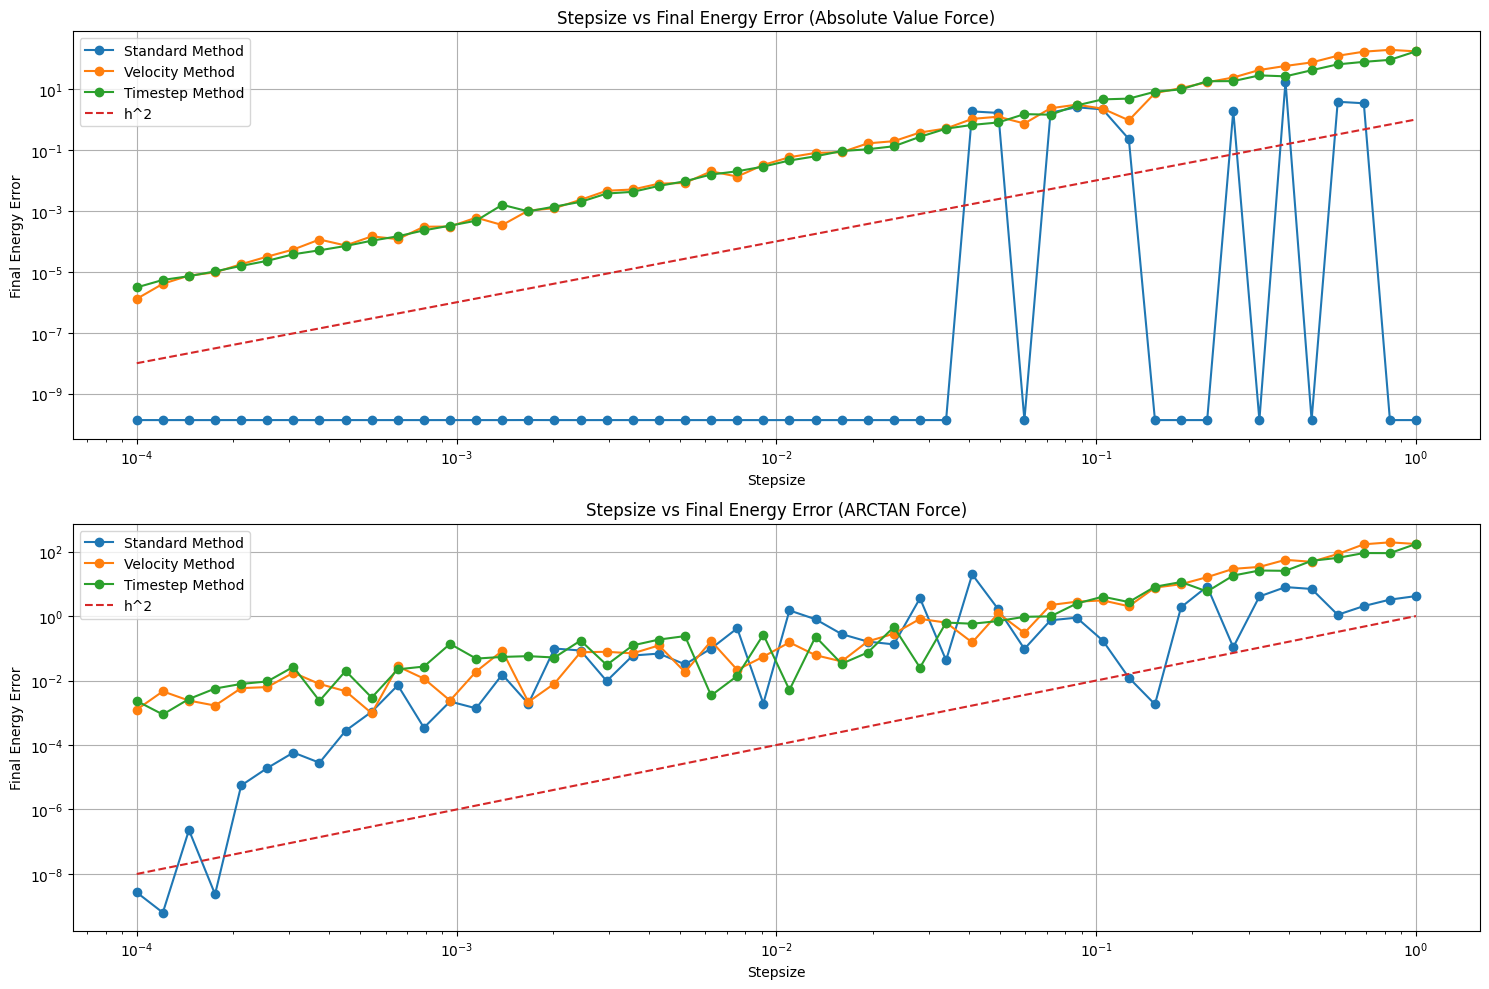

In [23]:
orbits = 10
x0 = 1
v0 = 0
T = 2 * np.pi * np.sqrt(x0/const.g)
x_s = 0.001

def create_force_arctan(x_s):
    return lambda x: -const.g * 2/np.pi * np.arctan(x/x_s)

def create_force_abs():
    return lambda x: -const.g * np.sign(x)

force_arctan = create_force_arctan(x_s)
force_abs = create_force_abs()

#Standard Solutions
def standard_numerical_solution(x0, v0, dt, T, orbits, force_fn):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    dt = t_final/(h-1)
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])

    return t, x, v

def standard_estimated_analytical_solution(x0, v0, dt, T, orbits, force_fn):
    dt = 1e-7 #Reference Time Step
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])

    return t, x, v

#Velocity Corrected Solutions
def velocity_corrected_numerical_solution(x0, v0, dt, T, orbits, force_fn):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    dt = t_final/(h-1)
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        if x[i] * x[i+1] < 0:
            v_half = v[i] + dt * 0.5 * force_fn(x[i])
            v_b = v[i] + (-x[i]/v_half) * force_fn(x[i])
            x[i+1] = x[i] + v_half * dt
            v[i+1] = v_b + ((x[i]/v_half) + dt) * force_fn(x[i+1])

        else:
            v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])

    return t, x, v

#Timestep Corrected Solutions
def timestep_corrected_numerical_solution(x0, v0, dt, T, orbits, force_fn):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    dt = t_final/(h-1)
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
       
        x_pre = x[i]
        v_pre = v[i]
        if x[i] * x[i+1] < 0:
            delta_t1 = -x_pre/v[i+1]
            delta_t2 = dt - delta_t1
            v[i+1] = v_pre + force_fn(x_pre) * delta_t1
            x[i+1] = x_pre + v[i+1] * dt
            v[i+1] = v[i+1] + force_fn(x[i+1]) * delta_t2

        else:
           v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1]) 

    return t, x, v

def calculate_energy_abs(x, v):
    potential_energy = const.g * np.abs(x) 
    kinetic_energy = 0.5 * v**2 
    return potential_energy + kinetic_energy

def calculate_energy_arctan(x, v, x_s):
    potential_energy = 2*const.g/np.pi * (x*np.arctan(x/x_s) - 0.5*x_s*np.log(x**2 + x_s**2))
    kinetic_energy = 0.5 * v**2
    return potential_energy + kinetic_energy

def analyze_energy_comparison(stepsizes, x0, v0, T, orbits, force_abs, force_arctan, x_s):
    # Reference solutions
    t_ref_abs, x_ref_abs, v_ref_abs = standard_estimated_analytical_solution(x0, v0, None, T, orbits, force_abs)
    E_ref_abs = calculate_energy_abs(x_ref_abs, v_ref_abs)
    
    t_ref_arctan, x_ref_arctan, v_ref_arctan = standard_estimated_analytical_solution(x0, v0, None, T, orbits, force_arctan)
    E_ref_arctan = calculate_energy_arctan(x_ref_arctan, v_ref_arctan, x_s)
    
    energy_errors_abs = {
        'standard': [],
        'velocity': [],
        'timestep': []
    }
    
    energy_errors_arctan = {
        'standard': [],
        'velocity': [],
        'timestep': []
    }

    stepsizes = np.logspace(-4,0,50)
    
    for dt in stepsizes:
        # ABS Force simulations
        t_std_abs, x_std_abs, v_std_abs = standard_numerical_solution(x0, v0, dt, T, orbits, force_abs)
        t_vel_abs, x_vel_abs, v_vel_abs = velocity_corrected_numerical_solution(x0, v0, dt, T, orbits, force_abs)
        t_ts_abs, x_ts_abs, v_ts_abs = timestep_corrected_numerical_solution(x0, v0, dt, T, orbits, force_abs)
        
        # ARCTAN Force simulations
        t_std_arctan, x_std_arctan, v_std_arctan = standard_numerical_solution(x0, v0, dt, T, orbits, force_arctan)
        t_vel_arctan, x_vel_arctan, v_vel_arctan = velocity_corrected_numerical_solution(x0, v0, dt, T, orbits, force_arctan)
        t_ts_arctan, x_ts_arctan, v_ts_arctan = timestep_corrected_numerical_solution(x0, v0, dt, T, orbits, force_arctan)
        
        # Calculate energies and errors for ABS force
        E_std_abs = calculate_energy_abs(x_std_abs, v_std_abs)
        E_vel_abs = calculate_energy_abs(x_vel_abs, v_vel_abs)
        E_ts_abs = calculate_energy_abs(x_ts_abs, v_ts_abs)
        
        err_std_abs = np.abs(E_std_abs[-1] - E_ref_abs[-1])
        err_vel_abs = np.abs(E_vel_abs[-1] - E_ref_abs[-1])
        err_ts_abs = np.abs(E_ts_abs[-1] - E_ref_abs[-1])
        
        # Calculate energies and errors for ARCTAN force
        E_std_arctan = calculate_energy_arctan(x_std_arctan, v_std_arctan, x_s)
        E_vel_arctan = calculate_energy_arctan(x_vel_arctan, v_vel_arctan, x_s)
        E_ts_arctan = calculate_energy_arctan(x_ts_arctan, v_ts_arctan, x_s)
        
        err_std_arctan = np.abs(E_std_arctan[-1] - E_ref_arctan[-1])
        err_vel_arctan = np.abs(E_vel_arctan[-1] - E_ref_arctan[-1])
        err_ts_arctan = np.abs(E_ts_arctan[-1] - E_ref_arctan[-1])
        
        # Store errors
        energy_errors_abs['standard'].append(err_std_abs)
        energy_errors_abs['velocity'].append(err_vel_abs)
        energy_errors_abs['timestep'].append(err_ts_abs)
        
        energy_errors_arctan['standard'].append(err_std_arctan)
        energy_errors_arctan['velocity'].append(err_vel_arctan)
        energy_errors_arctan['timestep'].append(err_ts_arctan)
    
    # Create plots
    plt.figure(figsize=(15, 10))
    
    # Plot ABS force errors
    plt.subplot(2, 1, 1)
    for method in ['standard', 'velocity', 'timestep']:
        plt.plot(stepsizes, energy_errors_abs[method], 
                marker='o', label=f'{method.capitalize()} Method')
    plt.plot(stepsizes, np.array(stepsizes)**2, linestyle='dashed', label='h^2')
    
    plt.xlabel('Stepsize')
    plt.ylabel('Final Energy Error')
    plt.title('Stepsize vs Final Energy Error (Absolute Value Force)')
    plt.grid(True)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    
    # Plot ARCTAN force errors
    plt.subplot(2, 1, 2)
    for method in ['standard', 'velocity', 'timestep']:
        plt.plot(stepsizes, energy_errors_arctan[method], 
                marker='o', label=f'{method.capitalize()} Method')
    plt.plot(stepsizes, np.array(stepsizes)**2, linestyle='dashed', label='h^2')
    
    plt.xlabel('Stepsize')
    plt.ylabel('Final Energy Error')
    plt.title('Stepsize vs Final Energy Error (ARCTAN Force)')
    plt.grid(True)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

analyze_energy_comparison(stepsizes, x0, v0, T, orbits, force_abs, force_arctan, x_s)

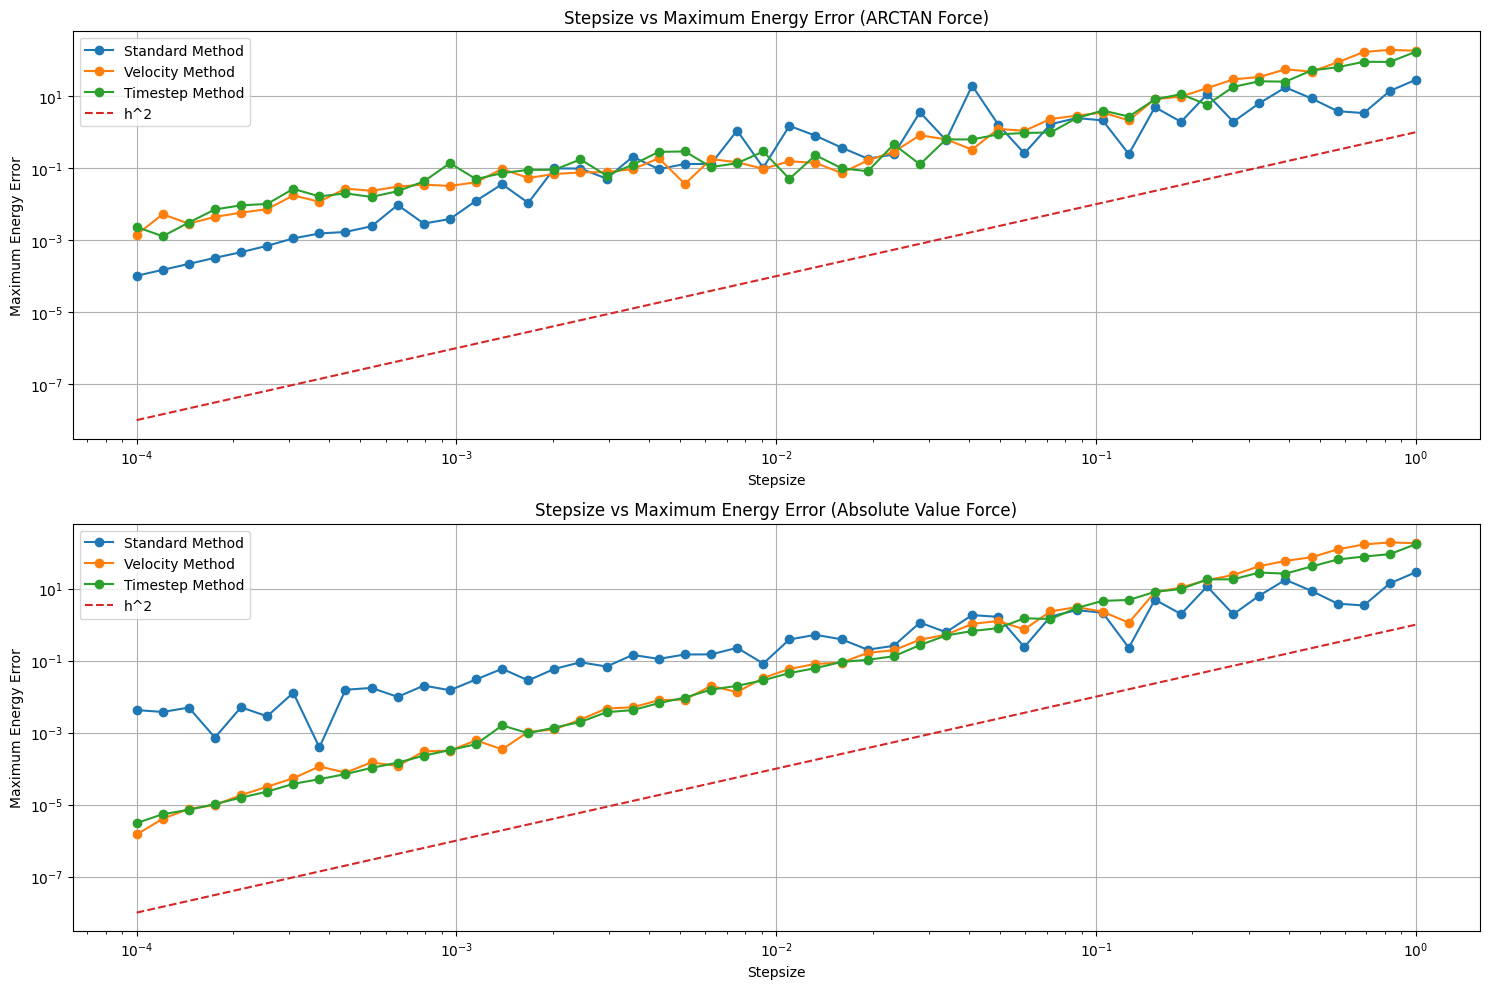

In [31]:
orbits = 10
x0 = 1
v0 = 0
T = 2 * np.pi * np.sqrt(x0/const.g)
x_s = 0.001

def create_force_arctan(x_s):
    return lambda x: -const.g * 2/np.pi * np.arctan(x/x_s)

def create_force_abs():
    return lambda x: -const.g * np.sign(x)

force_arctan = create_force_arctan(x_s)
force_abs = create_force_abs()

#Standard Solutions
def standard_numerical_solution(x0, v0, dt, T, orbits, force_fn):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    dt = t_final/(h-1)
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])

    return t, x, v

#Velocity Corrected Solutions
def velocity_corrected_numerical_solution(x0, v0, dt, T, orbits, force_fn):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    dt = t_final/(h-1)
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        if x[i] * x[i+1] < 0:
            v_half = v[i] + dt * 0.5 * force_fn(x[i])
            v_b = v[i] + (-x[i]/v_half) * force_fn(x[i])
            x[i+1] = x[i] + v_half * dt
            v[i+1] = v_b + ((x[i]/v_half) + dt) * force_fn(x[i+1])

        else:
            v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])

    return t, x, v

#Timestep Corrected Solutions
def timestep_corrected_numerical_solution(x0, v0, dt, T, orbits, force_fn):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    dt = t_final/(h-1)
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
       
        x_pre = x[i]
        v_pre = v[i]
        if x[i] * x[i+1] < 0:
            delta_t1 = -x_pre/v[i+1]
            delta_t2 = dt - delta_t1
            v[i+1] = v_pre + force_fn(x_pre) * delta_t1
            x[i+1] = x_pre + v[i+1] * dt
            v[i+1] = v[i+1] + force_fn(x[i+1]) * delta_t2

        else:
           v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1]) 

    return t, x, v

def calculate_energy_abs(x, v):
    potential_energy = const.g * np.abs(x) 
    kinetic_energy = 0.5 * v**2 
    return potential_energy + kinetic_energy

def calculate_energy_arctan(x, v, x_s):
    potential_energy = 2*const.g/np.pi * (x*np.arctan(x/x_s) - 0.5*x_s*np.log(x**2 + x_s**2))
    kinetic_energy = 0.5 * v**2
    return potential_energy + kinetic_energy

stepsizes = np.logspace(-4,0,50)

def analyze_relative_energy_error(stepsizes, x0, v0, T, orbits, force_abs, force_arctan=None, x_s=None):
    # Store relative energy errors
    rel_energy_errors = {
        'abs': {
            'standard': [],
            'velocity': [],
            'timestep': []
        }
    }
    
    # Add arctan if provided
    if force_arctan is not None:
        rel_energy_errors['arctan'] = {
            'standard': [],
            'velocity': [],
            'timestep': []
        }
    
    for dt in stepsizes:
        # ABS Force simulations
        t_std_abs, x_std_abs, v_std_abs = standard_numerical_solution(x0, v0, dt, T, orbits, force_abs)
        t_vel_abs, x_vel_abs, v_vel_abs = velocity_corrected_numerical_solution(x0, v0, dt, T, orbits, force_abs)
        t_ts_abs, x_ts_abs, v_ts_abs = timestep_corrected_numerical_solution(x0, v0, dt, T, orbits, force_abs)
        
        # Calculate energy time series for ABS force
        E_std_abs = calculate_energy_abs(x_std_abs, v_std_abs)
        E_vel_abs = calculate_energy_abs(x_vel_abs, v_vel_abs)
        E_ts_abs = calculate_energy_abs(x_ts_abs, v_ts_abs)
        
        # Initial energies
        E0_std_abs = E_std_abs[0]
        E0_vel_abs = E_vel_abs[0]
        E0_ts_abs = E_ts_abs[0]
        
        # Calculate maximum relative energy error
        max_err_std_abs = np.max(np.abs(E_std_abs - E0_std_abs))
        max_err_vel_abs = np.max(np.abs(E_vel_abs - E0_vel_abs))
        max_err_ts_abs = np.max(np.abs(E_ts_abs - E0_ts_abs))
        
        # Store relative errors
        rel_energy_errors['abs']['standard'].append(max_err_std_abs)
        rel_energy_errors['abs']['velocity'].append(max_err_vel_abs)
        rel_energy_errors['abs']['timestep'].append(max_err_ts_abs)
        
        # ARCTAN Force simulations (if provided)
        if force_arctan is not None:
            t_std_arctan, x_std_arctan, v_std_arctan = standard_numerical_solution(x0, v0, dt, T, orbits, force_arctan)
            t_vel_arctan, x_vel_arctan, v_vel_arctan = velocity_corrected_numerical_solution(x0, v0, dt, T, orbits, force_arctan)
            t_ts_arctan, x_ts_arctan, v_ts_arctan = timestep_corrected_numerical_solution(x0, v0, dt, T, orbits, force_arctan)
            
            # Calculate energy time series for ARCTAN force
            E_std_arctan = calculate_energy_arctan(x_std_arctan, v_std_arctan, x_s)
            E_vel_arctan = calculate_energy_arctan(x_vel_arctan, v_vel_arctan, x_s)
            E_ts_arctan = calculate_energy_arctan(x_ts_arctan, v_ts_arctan, x_s)
            
            # Initial energies
            E0_std_arctan = E_std_arctan[0]
            E0_vel_arctan = E_vel_arctan[0]
            E0_ts_arctan = E_ts_arctan[0]
            
            # Calculate maximum relative energy error
            max_err_std_arctan = np.max(np.abs(E_std_arctan - E0_std_arctan))
            max_err_vel_arctan = np.max(np.abs(E_vel_arctan - E0_vel_arctan))
            max_err_ts_arctan = np.max(np.abs(E_ts_arctan - E0_ts_arctan))
            
            # Store relative errors
            rel_energy_errors['arctan']['standard'].append(max_err_std_arctan)
            rel_energy_errors['arctan']['velocity'].append(max_err_vel_arctan)
            rel_energy_errors['arctan']['timestep'].append(max_err_ts_arctan)
    
    # Create plots
    plt.figure(figsize=(15, 10))
    
    # Plot ABS force errors
    plt.subplot(2, 1, 2)
    for method in ['standard', 'velocity', 'timestep']:
        plt.plot(stepsizes, rel_energy_errors['abs'][method], 
                marker='o', label=f'{method.capitalize()} Method')
    plt.plot(stepsizes, np.array(stepsizes)**2, linestyle='dashed', label='h^2')
    
    plt.xlabel('Stepsize')
    plt.ylabel('Maximum Energy Error')
    plt.title('Stepsize vs Maximum Energy Error (Absolute Value Force)')
    plt.grid(True)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    
    # Plot ARCTAN force errors
    if force_arctan is not None:
        plt.subplot(2, 1, 1)
        for method in ['standard', 'velocity', 'timestep']:
            plt.plot(stepsizes, rel_energy_errors['arctan'][method], 
                    marker='o', label=f'{method.capitalize()} Method')
        plt.plot(stepsizes, np.array(stepsizes)**2, linestyle='dashed', label='h^2')
        
        plt.xlabel('Stepsize')
        plt.ylabel('Maximum Energy Error')
        plt.title('Stepsize vs Maximum Energy Error (ARCTAN Force)')
        plt.grid(True)
        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return rel_energy_errors  

results = analyze_relative_energy_error(stepsizes, x0, v0, T, orbits, force_abs, force_arctan, x_s)

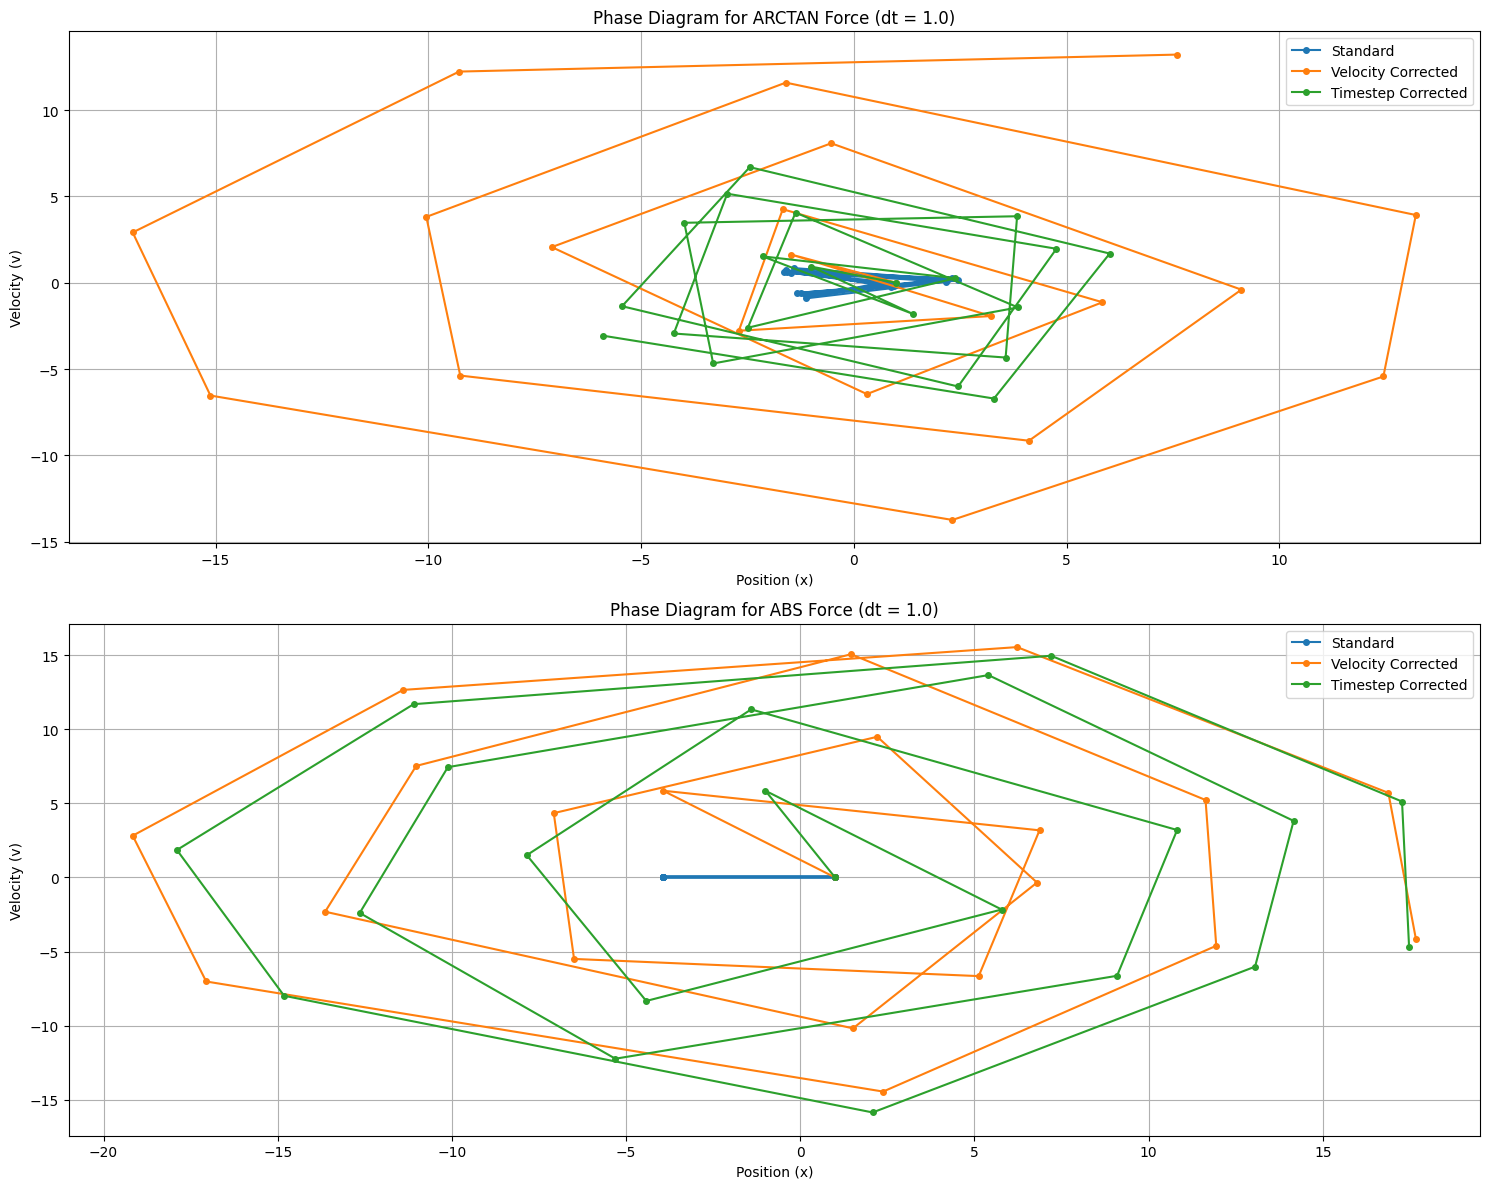

In [26]:
orbits = 10
x0 = 1
v0 = 0
x_s = 1
T = 2 * np.pi * np.sqrt(x0/const.g) 

# Force functions
def create_force_arctan(x_s):
    return lambda x: -const.g * 2/np.pi * np.arctan(x/x_s)

def create_force_abs():
    return lambda x: -const.g * np.sign(x)

force_arctan = create_force_arctan(x_s)
force_abs = create_force_abs()

# Numerical solutions
def standard_numerical_solution(x0, v0, dt, T, orbits, force_fn):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    dt = t_final/(h-1)
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])

    return t, x, v

def velocity_corrected_numerical_solution(x0, v0, dt, T, orbits, force_fn):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    dt = t_final/(h-1)
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        if x[i] * x[i+1] < 0:
            v_half = v[i] + dt * 0.5 * force_fn(x[i])
            v_b = v[i] + (-x[i]/v_half) * force_fn(x[i])
            x[i+1] = x[i] + v_half * dt
            v[i+1] = v_b + ((x[i]/v_half) + dt) * force_fn(x[i+1])
        else:
            v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1])

    return t, x, v

def timestep_corrected_numerical_solution(x0, v0, dt, T, orbits, force_fn):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    dt = t_final/(h-1)
    
    x = np.zeros(h)
    v = np.zeros(h)

    x[0] = x0
    v[0] = v0

    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v[i+1]
       
        x_pre = x[i]
        v_pre = v[i]
        if x[i] * x[i+1] < 0:
            delta_t1 = -x_pre/v[i+1]
            delta_t2 = dt - delta_t1
            v[i+1] = v_pre + force_fn(x_pre) * delta_t1
            x[i+1] = x_pre + v[i+1] * dt
            v[i+1] = v[i+1] + force_fn(x[i+1]) * delta_t2
        else:
           v[i+1] = v[i+1] + 0.5 * dt * force_fn(x[i+1]) 

    return t, x, v

dt_large = 1.0

# ARCTAN force
t_std_arctan, x_std_arctan, v_std_arctan = standard_numerical_solution(x0, v0, dt_large, T, orbits, force_arctan)
t_vel_arctan, x_vel_arctan, v_vel_arctan = velocity_corrected_numerical_solution(x0, v0, dt_large, T, orbits, force_arctan)
t_ts_arctan, x_ts_arctan, v_ts_arctan = timestep_corrected_numerical_solution(x0, v0, dt_large, T, orbits, force_arctan)


# ABS force
t_std_abs, x_std_abs, v_std_abs = standard_numerical_solution(x0, v0, dt_large, T, orbits, force_abs)
t_vel_abs, x_vel_abs, v_vel_abs = velocity_corrected_numerical_solution(x0, v0, dt_large, T, orbits, force_abs)
t_ts_abs, x_ts_abs, v_ts_abs = timestep_corrected_numerical_solution(x0, v0, dt_large, T, orbits, force_abs)

# Create phase diagrams
plt.figure(figsize=(15, 12))

# ARCTAN Force Phase Diagram
plt.subplot(2, 1, 1)
plt.plot(x_std_arctan, v_std_arctan, 'o-', label='Standard', markersize=4)
plt.plot(x_vel_arctan, v_vel_arctan, 'o-', label='Velocity Corrected', markersize=4)
plt.plot(x_ts_arctan, v_ts_arctan, 'o-', label='Timestep Corrected', markersize=4)
plt.xlabel('Position (x)')
plt.ylabel('Velocity (v)')
plt.title('Phase Diagram for ARCTAN Force (dt = 1.0)')
plt.grid(True)
plt.legend()

# ABS Force Phase Diagram
plt.subplot(2, 1, 2)
plt.plot(x_std_abs, v_std_abs, 'o-', label='Standard', markersize=4)
plt.plot(x_vel_abs, v_vel_abs, 'o-', label='Velocity Corrected', markersize=4)
plt.plot(x_ts_abs, v_ts_abs, 'o-', label='Timestep Corrected', markersize=4)
plt.xlabel('Position (x)')
plt.ylabel('Velocity (v)')
plt.title('Phase Diagram for ABS Force (dt = 1.0)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()